In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta
import warnings

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=720)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# 全撈 
one_year_ago_str = '20200101'

# SQL 查詢 加權指數
query_twse = f"""
SELECT *
FROM daily_twse
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
twse_df_raw = pd.read_sql(query_twse, engine)

stock_df_raw = pd.read_sql(query_stock, engine)

sub_category_list = pd.read_sql(query_sub_category, engine)



In [2]:
import numpy as np

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])

# stock_df_raw[(stock_df_raw['Date'] == '2024-04-01') & (stock_df_raw['成交筆數'] < 100) & (stock_df_raw['收盤價'] < 100)].copy() 
# stock_df_raw[(stock_df_raw['Date'] > '2024-04-01') & (stock_df_raw['證券代號'] == '1110' )]['成交筆數'].iloc[0]

In [3]:
# 短波強勢股
stock_date_list = stock_df_raw[(stock_df_raw['Date']>='2024-10-01' ) & (stock_df_raw['Date']<='2024-12-31' ) & (stock_df_raw['證券代號'] == '8028' ) ]['Date']
collected_data = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價', 'Date'])

pre_day = ""
rs20_rank_his = 100
# 檢查前波高低點差距
backday = 120

for day in stock_date_list:

        if(pre_day == ""):
               pre_day =  day
               continue

        stock_df_today = stock_df_raw[(stock_df_raw['Date'] == day) &  (stock_df_raw['20RS_rank'] > 52) & (stock_df_raw['60RS_rank'] > 90) & (stock_df_raw['240RS_rank'] > 90) & (stock_df_raw['收盤價'] > stock_df_raw['10MA'] )].copy() 
        stock_id_list = stock_df_today['證券代號'].tolist()

        for stock_id in stock_id_list:

                # 查前一天的 20RS_rank
                stock_his_df = stock_df_raw[(stock_df_raw['Date'] == pre_day) & (stock_df_raw['證券代號'] == stock_id )]
                # 會部會遇到剛好原本很弱 停牌隔天爆噴的可能
                if not stock_his_df.empty:
                        rs20_rank_his = stock_his_df['20RS_rank'].iloc[0]
                else:
                        # 停牌的話只能查stock_df_raw往前找了
                        stock_his_df = stock_df_raw[(stock_df_raw['Date'] < pre_day) & (stock_df_raw['證券代號'] == stock_id )]
                        if not stock_his_df.empty:
                                rs20_rank_his = stock_his_df['20RS_rank'].iloc[-1]
                                
                # 過去
                stock_today = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )].iloc[0]
                today_close = stock_today['收盤價']
                today_open = stock_today['開盤價']
                stock_name = stock_today['證券名稱']
                stock_volume = stock_today['成交筆數']

                # stock_af_volume = stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['成交筆數'].iloc[0]
                # stock_af_price  =  stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[0]
                # stock_af_price3  =  stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[3]
                
                if( (rs20_rank_his < 15) & (stock_volume > 1000) & (today_open <= today_close)):

                        # 檢查前波高低點
                        df_his_min_price = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] < day )]['收盤價'].rolling(backday).min().iloc[-1]
                        df_his_max_price = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] < day )]['收盤價'].rolling(backday).max().iloc[-1]
                        
                        if (df_his_min_price != 0) and (df_his_max_price != 0):

                                if (today_close / df_his_min_price > 3) or (df_his_max_price / today_close > 1.25):
                                        continue
                                
                        result_df = pd.DataFrame({
                                '證券代號': [ stock_id],
                                '證券名稱': [stock_name],
                                '收盤價': [today_close],
                                'Date': [day]
                                })
                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                collected_data = pd.concat([collected_data, result_df], ignore_index=True)

        # 更新pre day
        pre_day =  day

collected_data


C:\Users\USER\AppData\Local\Temp\ipykernel_11168\3173451259.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  collected_data = pd.concat([collected_data, result_df], ignore_index=True)


,證券代號,證券名稱,收盤價,Date
0,6231,系微,531.0,2024-10-07
1,4729,熒茂,28.6,2024-10-14
2,4571,鈞興-KY,167.5,2024-10-18
3,3550,聯穎,26.3,2024-10-21
4,8249,菱光,58.5,2024-10-21
5,1721,三晃,23.8,2024-10-23


舊的程式效能比較差已捨棄

In [3]:
# 存在本機
combined_df = pd.read_excel('c:/Users/USER/OneDrive/桌面/佛爾德/stock/combined_data_all2.xlsx')

# # ============================================
# test_data9 = collected_data
# stock_df_raw_tt = stock_df_raw[['Date','證券代號','5MA','10MA','20MA','60MA','20RS_rank','60RS_rank','240RS_rank']]
# merged_df = pd.merge(test_data9, stock_df_raw_tt, on=['Date', '證券代號'], how='inner')
# merged_df['5_boolean'] = merged_df['收盤價']> merged_df['5MA']
# merged_df['10_boolean'] = merged_df['收盤價']> merged_df['10MA']
# merged_df['20_boolean'] = merged_df['收盤價']> merged_df['20MA']
# merged_df['60_boolean'] = merged_df['收盤價']> merged_df['60MA']
# merged_df_2304 = merged_df.copy()


# # 縱向合併 merged_df_68 和 merged_df_46
# combined_df = pd.concat([combined_df, merged_df_2304], ignore_index=True)

# combined_df = combined_df.sort_values(by='Date')
# combined_df['Date'] = pd.to_datetime(combined_df['Date'])
# combined_df

In [9]:
# 如果還沒安裝 openpyxl，請先安裝：!pip install openpyxl
# 將 combined_df 存成 Excel 檔案
# 將 combined_df 存成 Excel 檔案到指定路徑

file_path = 'c:/Users/USER/OneDrive/桌面/佛爾德/stock/combined_data_all2.xlsx'
combined_df.to_excel(file_path, index=False)

combined_df_first = combined_df.drop_duplicates(subset='證券代號', keep='first')

符合條件者 
隔天收盤價買進
起算17天后收盤賣出

停損 : 出場看跌破60RS_RANK 88 隔天開盤直接賣出 


In [5]:
test_data12 = collected_data
stock_df_raw_tt = stock_df_raw[['Date','證券代號','5MA','10MA','20MA','60MA','20RS_rank','60RS_rank','240RS_rank']]
merged_df = pd.merge(test_data12, stock_df_raw_tt, on=['Date', '證券代號'], how='inner')
merged_df['5_boolean'] = merged_df['收盤價']> merged_df['5MA']
merged_df['10_boolean'] = merged_df['收盤價']> merged_df['10MA']
merged_df['20_boolean'] = merged_df['收盤價']> merged_df['20MA']
merged_df['60_boolean'] = merged_df['收盤價']> merged_df['60MA']
combined_df3 = merged_df.copy()
combined_df3

,證券代號,證券名稱,收盤價,Date,5MA,10MA,20MA,60MA,20RS_rank,60RS_rank,240RS_rank,5_boolean,10_boolean,20_boolean,60_boolean
0,2028,威致,22.75,2021-01-25,20.45,21.240,23.0925,18.8742,57.586207,93.505747,97.586207,True,True,False,True
1,6224,聚鼎,107.50,2021-02-05,100.26,101.920,104.1600,96.7300,87.263339,91.508893,90.189329,True,True,True,True
2,3092,鴻碩,66.80,2021-02-17,61.88,62.170,64.6750,58.9000,75.802752,90.309633,91.972477,True,True,True,True
3,6129,普誠,16.50,2021-02-17,15.38,15.865,16.3125,13.1557,58.600917,96.961009,98.050459,True,True,True,True
4,6284,佳邦,77.10,2021-02-17,72.96,73.620,75.3850,65.1717,68.807339,94.151376,97.534404,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,6138,茂達,253.50,2021-12-15,243.60,248.050,247.0750,197.6333,77.632328,95.162208,97.552647,True,True,True,True
65,6265,方土昶,18.60,2021-12-21,17.59,18.135,17.6175,13.3190,87.514253,98.004561,97.947548,True,True,True,True
66,8183,精星,70.90,2021-12-24,64.98,64.790,66.1150,53.2492,90.763968,96.294185,96.408210,True,True,True,True
67,6182,合晶,84.70,2021-12-27,82.52,82.510,83.6900,71.2183,54.410928,90.324417,93.340922,True,True,True,True


In [7]:
# import data 
combined_df = pd.read_excel('c:/Users/USER/OneDrive/桌面/佛爾德/stock/combined_data_all2.xlsx')

combined_df = combined_df[combined_df['收盤價'] < 400] # 400以上太貴算拉
combined_df

,證券代號,證券名稱,收盤價,Date,5MA,10MA,20MA,60MA,20RS_rank,60RS_rank,240RS_rank,5_boolean,10_boolean,20_boolean,60_boolean
0,2028,威致,22.75,2021-01-25,20.45,21.240,23.0925,18.8742,57.586207,93.505747,97.586207,True,True,False,True
1,6224,聚鼎,107.50,2021-02-05,100.26,101.920,104.1600,96.7300,87.263339,91.508893,90.189329,True,True,True,True
2,3092,鴻碩,66.80,2021-02-17,61.88,62.170,64.6750,58.9000,75.802752,90.309633,91.972477,True,True,True,True
3,6129,普誠,16.50,2021-02-17,15.38,15.865,16.3125,13.1557,58.600917,96.961009,98.050459,True,True,True,True
4,6284,佳邦,77.10,2021-02-17,72.96,73.620,75.3850,65.1717,68.807339,94.151376,97.534404,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,8028,昇陽半導體,125.50,2024-09-13,118.20,120.850,126.5250,114.3733,58.221024,90.296496,97.897574,True,True,False,True
192,6535,順藥,256.50,2024-09-16,243.60,246.100,250.7750,231.4083,79.094828,90.355603,96.982759,True,True,True,True
193,4716,大立,24.95,2024-09-18,23.22,23.055,24.1275,21.8942,85.183190,93.157328,94.558190,True,True,True,True
194,6151,晉倫,40.80,2024-09-18,37.59,38.920,40.3975,34.2175,72.090517,95.797414,92.887931,True,True,True,True


In [8]:
test_data12 = combined_df
stock_df_raw_tt = stock_df_raw[['Date','證券代號','開盤價']]
test_data12['證券代號'] = test_data12['證券代號'].astype(str)
stock_df_raw_tt['證券代號'] = stock_df_raw_tt['證券代號'].astype(str)
combined_df = pd.merge(test_data12, stock_df_raw_tt, on=['Date', '證券代號'], how='inner')
combined_df

C:\Users\USER\AppData\Local\Temp\ipykernel_11168\2327384216.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df_raw_tt['證券代號'] = stock_df_raw_tt['證券代號'].astype(str)


,證券代號,證券名稱,收盤價,Date,5MA,10MA,20MA,60MA,20RS_rank,60RS_rank,240RS_rank,5_boolean,10_boolean,20_boolean,60_boolean,開盤價
0,2028,威致,22.75,2021-01-25,20.45,21.240,23.0925,18.8742,57.586207,93.505747,97.586207,True,True,False,True,21.25
1,6224,聚鼎,107.50,2021-02-05,100.26,101.920,104.1600,96.7300,87.263339,91.508893,90.189329,True,True,True,True,98.60
2,3092,鴻碩,66.80,2021-02-17,61.88,62.170,64.6750,58.9000,75.802752,90.309633,91.972477,True,True,True,True,62.10
3,6129,普誠,16.50,2021-02-17,15.38,15.865,16.3125,13.1557,58.600917,96.961009,98.050459,True,True,True,True,16.40
4,6284,佳邦,77.10,2021-02-17,72.96,73.620,75.3850,65.1717,68.807339,94.151376,97.534404,True,True,True,True,72.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,8028,昇陽半導體,125.50,2024-09-13,118.20,120.850,126.5250,114.3733,58.221024,90.296496,97.897574,True,True,False,True,120.00
184,6535,順藥,256.50,2024-09-16,243.60,246.100,250.7750,231.4083,79.094828,90.355603,96.982759,True,True,True,True,238.00
185,4716,大立,24.95,2024-09-18,23.22,23.055,24.1275,21.8942,85.183190,93.157328,94.558190,True,True,True,True,22.85
186,6151,晉倫,40.80,2024-09-18,37.59,38.920,40.3975,34.2175,72.090517,95.797414,92.887931,True,True,True,True,37.40


In [11]:
# 調整購買比重

def weighted_price(price):
    if price < 20:
        return price * 20
    
    elif 20 <= price < 40:
        return price * 10  
    
    elif 40 <= price < 50:
        return price * 8  
    
    elif 50 <= price < 65:
        return price * 6    
      
    elif 65 <= price < 80:
        return price * 5    
    
    elif 80 <= price < 100:
        return price * 4

    elif 100 <= price < 130:
        return price * 3  
    
    elif 130 <= price < 200:
        return price * 2  
    
    elif 200 <= price :
        return price * 1  

備用 先不要動 改造新的 希望可以達成資金控管

In [79]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# 拿來當日期基準值
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']

loss_pen = 1
loss_type = 0
rs_rank_list = list(range(21, 22, 1)) # 77 

total_earn_data = pd.DataFrame(columns=['hold_day','60rs_rank','20rs_rank',
                                        'total_earn_close','total_earn_open','total_earn_mix','total_earn_nonsetloss_close','total_earn_nonsetloss_open' ,
                                        'len',
                                        'earn_close_min','earn_open_min','earn_mix_min','earn_nonsetloss_open_min','earn_nonsetloss_close_min',
                                        'daily_need_money_max','daily_need_money_min','avg_hold_day' ,'total_earn_moeny'])
for j in rs_rank_list:
    k = 80 # 60天RS
    
    

    earn_date_list = pd.DataFrame(columns=['證券代號','證券名稱','select_day',
                                           '開盤價', '收盤價',
                                           '明天收盤價','明天開盤價',
                                           '後天收盤價','後天開盤價',
                                           'X天收盤價','earn_mix賣出價',
                                           'earn_close','earn_open','earn_mix',
                                           'earn_nonsetloss_close','earn_nonsetloss_open',
                                           'buy_date', 'sell_date',
                                           'RS20','RS60','RS240',
                                           'loss_type',
                                           'GMFE','MAE','BMFE',
                                           'real_hold_day','not_sl_sell_date',
                                           'VOL','VOL5','VOL10','VOL20','VOL60'])
    
    for i in range(len(combined_df)): # 這次跑的策略股票
        # 取出單一各股
        stock = combined_df.iloc[i]

        # 單一個股資本資訊
        stock_id = stock['證券代號']
        stock_name = stock['證券名稱']
        today_open = stock['開盤價']
        today_close = stock['收盤價']
        select_day = stock['Date']
        RS20 = stock['20RS_rank']
        RS60 = stock['60RS_rank']
        RS240 = stock['240RS_rank']

        # MAE之前發生的最大有利方向幅度
        BMFE = 0
        # 全域最大有利方向幅度
        GMFE = 0
        # 最大不利方向幅度
        MAE = 0

        stock_af = stock_df_raw[(stock_df_raw['Date'] > select_day.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id))].copy() 

        # 短波策略預計要抱 16 天 如果太新的股票先不列入
        if(len(stock_af) <  j+1):
              continue
        
        # 研究一下量價關係
        stock_bf = stock_df_raw[(stock_df_raw['Date'] <= select_day.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id))].copy() 
        VOL =   stock_bf['成交筆數'].iloc[-1] 
        VOL5  = stock_bf['成交筆數'].rolling(5).mean().iloc[-1]
        VOL10 = stock_bf['成交筆數'].rolling(10).mean().iloc[-1]
        VOL20 = stock_bf['成交筆數'].rolling(20).mean().iloc[-1]
        VOL60 = stock_bf['成交筆數'].rolling(60).mean().iloc[-1]
        # 研究一下量價關係

        # 直接排除 想法是 不要爆太大量
        if(VOL > VOL20):
            continue

        stock_close_price = stock_af['收盤價'].iloc[0] 
        stock_open_price = stock_af['開盤價'].iloc[0]

        if( 100 * ((stock_close_price - stock_open_price) / stock_open_price) > 9 ):
            # 隔天收盤要買的時候太貴不追 放棄交易
            continue

        stock_close_price1 = stock_af['收盤價'].iloc[1] 
        stock_open_price1 = stock_af['開盤價'].iloc[1]

        buy_date = stock_af['Date'].iloc[0]

        stock_af_price_close = stock_af['收盤價'].iloc[j] # 賣出價收盤價
        earn_mix_sell_price = stock_af_price_close

        stock_af_price_open = stock_af['開盤價'].iloc[j] # 賣出價開盤價

        sell_date = stock_af['Date'].iloc[j] # 賣出日
        not_sl_sell_date = stock_af['Date'].iloc[j]

        # 設定停損 RS RANK 停損
        loss_price = stock_close_price * loss_pen # 買進價的
        stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & 
                                   (stock_df_raw['Date'] > buy_date ) & 
                                   ((stock_df_raw['60RS_rank'] < k)  | (stock_df_raw['20RS_rank'] < 20) ) ].copy() # 避免假突破
        

        # 設定停損 價格停損
        # loss_price = stock_close_price * loss_pen # 買進價的
        # stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] > buy_date ) & (stock_df_raw['收盤價'] < loss_price)].copy()


        # 設定停損 RS RANK 停損
        # loss_price = stock_close_price * loss_pen # 買進價的
        # stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == stock_id) & (stock_df_raw['Date'] > buy_date ) & (stock_df_raw['收盤價'] < stock_df_raw['10MA'])].copy()



        # 測試如果完全不停損    
        earn_nonsetloss_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
        earn_nonsetloss_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
        loss_type = '1'


        # 計算 MAE BMFE GMFE
        stock_af_forMAE = stock_df_raw[(stock_df_raw['Date'] > buy_date.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] <= sell_date.strftime('%Y-%m-%d')) ].copy() 
        
        # 全域最大有利方向幅度
        GMFE = round( 100*((stock_af_forMAE['收盤價'].max()/stock_close_price)-1),2 )
        if (GMFE < 0):
            GMFE = 0
        # 全域最大不利方向幅度
        MAE = round( 100*((stock_af_forMAE['收盤價'].min()/stock_close_price)-1),2 )
        if (MAE > 0):
            MAE = 0

        MAE_day = stock_af_forMAE[stock_af_forMAE['收盤價'] == stock_af_forMAE['收盤價'].min()]['Date'].iloc[0]
        B_MAE_Date = stock_af_forMAE[stock_af_forMAE['Date'] <= MAE_day]

        # 全域最大有利方向幅度 (全域最大不利方向幅度前)
        BMFE = round( 100*((B_MAE_Date['收盤價'].max()/stock_close_price)-1),2 )

        if (BMFE < 0):
            BMFE = 0       

        # 多判斷是否停損不續抱著 
        if not stoploss_df.empty:
                stoploss_day_df = stoploss_df.iloc[0] # 符合條件當天停損

                if (stoploss_day_df['Date'] < sell_date):
                    # 需要隔天才能確認停損
                    stoploss_df_tommorrow = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] > stoploss_day_df['Date'].strftime('%Y-%m-%d'))].copy()
                    tommorrow_df = stoploss_df_tommorrow.iloc[0]

                    earn_close = round( 100*((tommorrow_df['收盤價']/stock_close_price)-1),2 )  #隔天收盤停損
                    earn_open = round( 100*((tommorrow_df['開盤價']/stock_close_price)-1),2 ) #隔天開盤停損
                    earn_mix = round( 100*((tommorrow_df['開盤價']/stock_close_price)-1),2 ) #隔天開盤停損

                    sell_date = tommorrow_df['Date'] 
                    loss_type = '2'

                    earn_mix_sell_price = tommorrow_df['開盤價']

                else:
                      earn_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
                      earn_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
                      earn_mix = round( 100*((stock_af_price_close/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣
                      earn_mix_sell_price = stock_af_price_close

        else :
            earn_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
            earn_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
            earn_mix = round( 100*((stock_af_price_close/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣
            earn_mix_sell_price = stock_af_price_close

        # 如果買完有拉漲停就出掉了 漲太快
        # 沒用 目前沒有第三天還快漲停的Q
        # if( 100 * ((stock_close_price1 - stock_open_price1) / stock_open_price1) > 9 ):
        #     earn_mix = round( 100*((stock_close_price1/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣
        #     earn_mix_sell_price = stock_close_price1
        #     sell_date = stock_af['Date'].iloc[1] 


        real_hold_day = len(stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] >= buy_date) & (stock_df_raw['Date'] <= sell_date)])

        result_df = pd.DataFrame({
            '證券代號': [stock_id],
            '證券名稱': [stock_name],
            'select_day': [select_day],
            '開盤價': [today_open],
            '收盤價': [today_close],
            '明天收盤價': [stock_close_price],
            '明天開盤價': [stock_open_price],
            '後天收盤價': [stock_close_price1],
            '後天開盤價': [stock_open_price1],
            'X天收盤價': [stock_af_price_close],
            'earn_mix賣出價': [earn_mix_sell_price],
            'earn_close':[earn_close],
            'earn_open':[earn_open],
            'earn_mix':[earn_mix],
            'earn_nonsetloss_close':[earn_nonsetloss_close],
            'earn_nonsetloss_open':[earn_nonsetloss_open],
            'buy_date': [buy_date],
            'sell_date': [sell_date],
            'RS20': [RS20],
            'RS60': [RS60],
            'RS240': [RS240],
            'loss_type': [loss_type],
            'GMFE': [GMFE],
            'MAE': [MAE],
            'BMFE': [BMFE],
            'real_hold_day':[real_hold_day],
            'not_sl_sell_date':[not_sl_sell_date],
            'VOL':[VOL],
            'VOL5':[VOL5],
            'VOL10':[VOL10],
            'VOL20':[VOL20],
            'VOL60':[VOL60]
            })
        
        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)
        if not result_df.empty:
                earn_date_list = pd.concat([earn_date_list, result_df], ignore_index=True) 


    total_earn_close = earn_date_list['earn_close'].cumsum()    
    total_earn_open = earn_date_list['earn_open'].cumsum()    
    total_earn_mix= earn_date_list['earn_mix'].cumsum()    
    total_earn_nonsetloss_close = earn_date_list['earn_nonsetloss_close'].cumsum()    
    total_earn_nonsetloss_open = earn_date_list['earn_nonsetloss_open'].cumsum()    

    # 另外計算 ==============================
    earn_date_list['weighted_price'] = earn_date_list['明天收盤價'].apply(weighted_price)
    earn_date_list['weighted_earn_price'] = earn_date_list['weighted_price'] * earn_date_list['earn_mix'] / 100

    # tt = collected_data_day[['證券名稱','證券代號','明天收盤價','buy_date','sell_date', 'daily_return','earn_nonsetloss_close','real_hold_day']]
    
    need_price_list = pd.DataFrame(columns=['hold_day','stock_id', 'daily_return','need_price'])

    for i in range(len(earn_date_list)):
        stock_info = earn_date_list.iloc[i]
        buy_date = stock_info['buy_date']
        sell_date = stock_info['sell_date']
        need_price = stock_info['weighted_price'] # 加權過後的明日收盤價

        # not_sl_sell_date = stock_info['not_sl_sell_date']

        stock_id = stock_info['證券代號']
        
        Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

        for day in Date_list:
            temp_df = pd.DataFrame({
                'hold_day': [day],
                'stock_id' : [stock_id],
                'need_price':[need_price]
            })

            # 删除全为NA的列，避免可能出现的警告
            temp_df.dropna(axis=1, how='all', inplace=True)
            if not temp_df.empty:
                need_price_list = pd.concat([need_price_list, temp_df], ignore_index=True)

        # 另外計算 ==============================

    earn_df = pd.DataFrame({
        'hold_day': [j],
        '60rs_rank': [k],
        '20rs_rank': [20],
        'total_earn_close': [total_earn_close.iloc[-1]],
        'total_earn_open': [total_earn_open.iloc[-1]],
        'total_earn_mix': [total_earn_mix.iloc[-1]],
        'total_earn_nonsetloss_close': [total_earn_nonsetloss_close.iloc[-1]],
        'total_earn_nonsetloss_open': [total_earn_nonsetloss_open.iloc[-1]],
        'len': [len(earn_date_list[earn_date_list['loss_type'] == '2'])],
        'earn_close_min': [earn_date_list['earn_close'].min()],
        'earn_open_min': [earn_date_list['earn_open'].min()],
        'earn_mix_min': [earn_date_list['earn_mix'].min()],
        'earn_nonsetloss_open_min': [earn_date_list['earn_nonsetloss_open'].min()],
        'earn_nonsetloss_close_min': [earn_date_list['earn_nonsetloss_close'].min()],
        'daily_need_money_max':[need_price_list.groupby('hold_day')['need_price'].sum().max()],
        'daily_need_money_min':[need_price_list.groupby('hold_day')['need_price'].sum().min()], 
        'avg_hold_day':[len(need_price_list)/len(earn_date_list)],
        'total_earn_moeny':[earn_date_list['weighted_earn_price'].cumsum().iloc[-1]]
        })

        # 删除全为NA的列，避免可能出现的警告
    earn_df.dropna(axis=1, how='all', inplace=True)

    if not earn_df.empty:
            total_earn_data = pd.concat([total_earn_data, earn_df], ignore_index=True) 

total_earn_data



,hold_day,60rs_rank,20rs_rank,total_earn_close,total_earn_open,total_earn_mix,total_earn_nonsetloss_close,total_earn_nonsetloss_open,len,earn_close_min,earn_open_min,earn_mix_min,earn_nonsetloss_open_min,earn_nonsetloss_close_min,daily_need_money_max,daily_need_money_min,avg_hold_day,total_earn_moeny
0,21,80,20,877.84,835.12,871.65,966.97,859.88,52,-15.38,-11.57,-11.57,-30.67,-29.4,2477.1,215.5,12.397059,2982.94648


In [72]:
len(earn_date_list)

188

In [73]:
earn_date_list['earn_mix'].mean()

5.506595744680851

In [16]:
total_earn_data

,hold_day,60rs_rank,20rs_rank,total_earn_close,total_earn_open,total_earn_mix,total_earn_nonsetloss_close,total_earn_nonsetloss_open,len,earn_close_min,earn_open_min,earn_mix_min,earn_nonsetloss_open_min,earn_nonsetloss_close_min,daily_need_money_max,daily_need_money_min,avg_hold_day,total_earn_moeny
0,21,80,20,746.85,692.46,728.07,741.49,652.26,40,-11.19,-13.63,-13.63,-30.67,-29.4,2477.1,215.5,12.730769,2541.77906


In [189]:
total_earn_data

,hold_day,60rs_rank,20rs_rank,total_earn_close,total_earn_open,total_earn_mix,total_earn_nonsetloss_close,total_earn_nonsetloss_open,len,earn_close_min,earn_open_min,earn_mix_min,earn_nonsetloss_open_min,earn_nonsetloss_close_min,daily_need_money_max,daily_need_money_min,avg_hold_day,total_earn_moeny
0,21,80,20,1002.49,1006.37,1027.97,1164.53,1018.37,149,-19.41,-15.22,-15.22,-35.93,-29.4,4637.3,162.4,12.016216,3445.56893


研究 delay entry

In [275]:
earn_date_list['select_day_diff'] = 100 * (earn_date_list['收盤價'] - earn_date_list['開盤價']) / earn_date_list['開盤價']
earn_date_list['tomorrow_day_diff'] = 100 * (earn_date_list['明天收盤價'] - earn_date_list['明天開盤價']) / earn_date_list['明天開盤價']
earn_date_list['tomorrow_day_diff2'] = 100 * (earn_date_list['後天收盤價'] - earn_date_list['後天開盤價']) / earn_date_list['後天開盤價']
column = 'earn_mix'

print('=第一天=============================================================================================')
for i in range(0,10,1):
    print(str(i) + " : "+ str( round(earn_date_list[earn_date_list['select_day_diff'] > i ][column].mean() ,2)  ))
print('=第二天=============================================================================================')
for i in range(0,10,1):
    print(str(i) + " : " + str(len(earn_date_list[earn_date_list['tomorrow_day_diff'] > i ])) + " : "  + str(round( earn_date_list[earn_date_list['tomorrow_day_diff'] > i ][column].mean(),2 ) ))
print('=第三天=============================================================================================')
for i in range(0,10,1):
    print(str(i) + " : " + str(len(earn_date_list[earn_date_list['tomorrow_day_diff'] > i ])) + " : "  + str(round(earn_date_list[earn_date_list['tomorrow_day_diff2'] > i ][column].mean(),2 ) ))
# earn_date_list[earn_date_list['select_day_diff'] > 9 ][['select_day','證券代號', '證券名稱', '開盤價', '收盤價', '明天開盤價', '明天收盤價','earn_mix','real_hold_day']]
# earn_date_list[earn_date_list['tomorrow_day_diff2'] > 7 ][['select_day','證券代號', '證券名稱', '開盤價', '收盤價', '明天開盤價', '明天收盤價','earn_mix','real_hold_day']]

=第一天=============================================================================================
0 : 12.04
1 : 8.76
2 : 9.06
3 : 9.41
4 : 10.61
5 : 9.48
6 : 10.55
7 : 10.03
8 : 6.56
9 : -4.87
=第二天=============================================================================================
0 : 22 : 16.71
1 : 17 : 21.22
2 : 12 : 24.48
3 : 9 : 25.62
4 : 6 : 32.43
5 : 6 : 32.43
6 : 5 : 38.41
7 : 3 : 14.83
8 : 2 : -7.62
9 : 1 : -13.63
=第三天=============================================================================================
0 : 22 : 14.0
1 : 17 : 10.73
2 : 12 : 10.88
3 : 9 : 8.58
4 : 6 : 8.16
5 : 6 : 5.67
6 : 5 : 9.62
7 : 3 : -1.03
8 : 2 : nan
9 : 1 : nan


研究 量價關係 看起來20MA VOL好像有點東西

In [52]:
loss_type_stock = earn_date_list[earn_date_list['earn_mix'] > 0]
print(len(loss_type_stock))
print( len(loss_type_stock[loss_type_stock['VOL']>loss_type_stock['VOL60']]) / len(loss_type_stock) ) 
print("==================")
print(len(earn_date_list))
print( len(earn_date_list[earn_date_list['VOL']>earn_date_list['VOL60']] ) / len(earn_date_list)) 

72
0.6944444444444444
185
0.7621621621621621


In [14]:
loss_type_stock = earn_date_list[earn_date_list['VOL']>=earn_date_list['VOL20']]
print(len(loss_type_stock))
print( loss_type_stock['earn_mix'].mean() )
print( loss_type_stock['earn_mix'].min() )
print("==================")
loss_type_stock = earn_date_list[earn_date_list['VOL']<earn_date_list['VOL20']]
print(len(loss_type_stock))
print( loss_type_stock['earn_mix'].mean() ) 
print( loss_type_stock['earn_mix'].min() )

119
1.4892436974789915
-15.22
69
12.435072463768119
-13.63


In [177]:
loss_type_stock = earn_date_list[earn_date_list['earn_mix'] < 0]

print(loss_type_stock[loss_type_stock['VOL']>loss_type_stock['VOL20']]['earn_mix'].mean() )
print(loss_type_stock[loss_type_stock['VOL']<loss_type_stock['VOL20']]['earn_mix'].mean() )

print("==60================")
print(earn_date_list[earn_date_list['VOL']>earn_date_list['VOL60']]['earn_mix'].mean() )
print(len(earn_date_list[earn_date_list['VOL']<earn_date_list['VOL60']]) )

print(earn_date_list[earn_date_list['VOL']<earn_date_list['VOL60']]['earn_mix'].mean() )

print("==20================")
print(earn_date_list[earn_date_list['VOL']>earn_date_list['VOL20']]['earn_mix'].mean() )
print(len(earn_date_list[earn_date_list['VOL']<earn_date_list['VOL20']]) )

print(earn_date_list[earn_date_list['VOL']<earn_date_list['VOL20']]['earn_mix'].mean() )

print("==10================")
print(earn_date_list[earn_date_list['VOL']>earn_date_list['VOL10']]['earn_mix'].mean() )
print(earn_date_list[earn_date_list['VOL']<earn_date_list['VOL10']]['earn_mix'].mean() )

print("==5================")
print(earn_date_list[earn_date_list['VOL']>earn_date_list['VOL5']]['earn_mix'].mean() )
print(earn_date_list[earn_date_list['VOL']<earn_date_list['VOL5']]['earn_mix'].mean() )

# earn_date_list[earn_date_list['VOL']>earn_date_list['VOL20']].sort_values(by='earn_mix', ascending=True).head(30)[['select_day','證券代號', '證券名稱', '開盤價', '收盤價','earn_mix','real_hold_day']]

# earn_date_list[earn_date_list['VOL']<earn_date_list['VOL20']].tail(50)

-6.267012987012987
-5.064705882352942
==60================
2.4865248226950354
44
15.394772727272727
==20================
1.39008547008547
68
12.725441176470591
==10================
4.944516129032259
8.719000000000001
==5================
4.837869822485207
13.148125


跟猜想的依樣 那些沒有篩出 VOL < 20 的時候 就算硬是去買 VOL > 20 效果也不好 earn 25%光交易稅可能就剩下不多了!

In [188]:
# Step 1: Find select_day values that appear more than once
select_day_counts = earn_date_list['select_day'].value_counts()
multiple_select_days = select_day_counts[select_day_counts > 1].index

# Step 2: Filter the DataFrame for those select_day values and VOL < VOL20
filtered_df = earn_date_list[
    (earn_date_list['select_day'].isin(multiple_select_days)) & 
    (earn_date_list['VOL'] < earn_date_list['VOL20'])
]

# Preview the filtered data
len(filtered_df)
filtered_df['earn_mix'].sum()

# earn_date_list[earn_date_list['select_day'] == '2021-05-28']

430.87

證券代號	證券名稱	收盤價	Date
0	6231	系微	531.0	2024-10-07
1	4729	熒茂	28.6	2024-10-14
2	4571	鈞興-KY	167.5	2024-10-18
3	3550	聯穎	26.3	2024-10-21
4	8249	菱光	58.5	2024-10-21

In [ ]:
print('===不管怎樣都是收盤在買最好======================================')
for i in range(-10,10,1):
    print(earn_date_list[earn_date_list['select_day_diff'] > i ]['tomorrow_day_diff'].mean())

計算勝率 賠率  嘗試套用凱利公式

In [99]:
print(len(earn_date_list['earn_mix'] > 0))
print(len(earn_date_list['earn_mix'] <= 0))

print(earn_date_list[earn_date_list['earn_mix'] <= 0]['earn_mix'].mean())
print(earn_date_list[earn_date_list['earn_mix'] > 0]['earn_mix'].mean())


185
185
-5.7943362831858405
23.371249999999996


In [215]:
# 如果每天要買得有多筆 用平均的話呢?
calculate_column = 'earn_mix'

earn_date_list['buy_date'] = pd.to_datetime(earn_date_list['buy_date'])

earn_date_list_group_mean = earn_date_list[['buy_date', calculate_column]]
earn_date_list_group_mean = earn_date_list_group_mean.groupby('buy_date')[calculate_column].mean()

earn_date_list_group_mean.columns = ['buy_date', calculate_column]
earn_date_list_group_mean = earn_date_list_group_mean.to_frame(name=calculate_column)
print(len(earn_date_list))
# earn_date_list[calculate_column].cumsum()
earn_date_list_group_mean['earn_mix'].sum()

68


649.8741666666668

In [104]:
earn_date_list_vol20 = earn_date_list[earn_date_list['VOL']<earn_date_list['VOL20']] 
earn_date_list_vol20['earn_mix'].min()

-13.63

In [103]:
import numpy as np

# 假設 collected_data_day 已經定義
max_loss = earn_date_list_vol20['earn_mix'].min()
result_list = []
f_list = []  # 保存對應的 f 值
f = 0.01

# 迴圈計算不同 f 對應的 HPR 和幾何平均
for f in np.arange(0.01, 1, 0.01):
    
    HPR_list = []
    for i in range(len(earn_date_list_vol20)):
        HPR =  1 + round(f, 2) * (earn_date_list_vol20['earn_mix'].iloc[i] / max_loss)
        HPR_list.append(HPR)

    # 計算連續多筆相乘
    product_of_HPR = np.prod(HPR_list)

    # 開 n 次方 (n 是數列的長度)
    n = len(HPR_list)
    result = product_of_HPR ** (1/n)  
    result_list.append(result)  # 保存結果
    f_list.append(f)  # 保存對應的 f 值

# 找到 result_list 中的最大值及其對應的 f 值
max_result = max(result_list)
max_index = result_list.index(max_result)
optimal_f = f_list[max_index]

print(f"result_list 中的最大值是: {max_result}")
print(f"對應的最佳化 f 值是: {optimal_f}")


result_list 中的最大值是: 1.3395023616168715
對應的最佳化 f 值是: 0.99


C:\Users\USER\AppData\Local\Temp\ipykernel_7564\743358569.py:22: RuntimeWarning: invalid value encountered in scalar power
  result = product_of_HPR ** (1/n)


In [235]:
select_day_counts = earn_date_list['select_day'].value_counts()
select_day_counts[select_day_counts == 4]

select_day
2021-05-28    4
Name: count, dtype: int64

In [90]:
# 試著將持倉調整為最多五檔
# 目前持倉
Date_list = stock_df_raw[(stock_df_raw['證券代號'] == '2330') & (stock_df_raw['Date'] >= '2021-02-17') & (stock_df_raw['Date'] <= '2024-09-16') ]['Date']

my_stock_hold = pd.DataFrame(columns=['count','buy_date'])

exit_stock_list  = pd.DataFrame(columns=['證券代號','證券名稱','select_day',
                                           '開盤價', '收盤價',
                                           '明天收盤價','明天開盤價',
                                           '後天收盤價','後天開盤價',
                                           'X天收盤價','earn_mix賣出價',
                                           'earn_close','earn_open','earn_mix',
                                           'earn_nonsetloss_close','earn_nonsetloss_open',
                                           'buy_date', 'sell_date',
                                           'RS20','RS60','RS240',
                                           'loss_type',
                                           'GMFE','MAE','BMFE',
                                           'real_hold_day','not_sl_sell_date',
                                           'VOL','VOL5','VOL10','VOL20','VOL60'])
hold_count = 0

for select_day in Date_list:

    position_stock = earn_date_list[(earn_date_list['buy_date'] <= select_day) & (earn_date_list['sell_date'] >= select_day) ]  # 同一天沒關係 剛好交割起來

    temp_data = pd.DataFrame ({
        'count' :[len(position_stock)],
        'buy_date' :[select_day]
    })

    if (hold_count >= 5):
        today_stock = earn_date_list[(earn_date_list['buy_date'] == select_day)]
        hold_count = len(position_stock)

        if (len(today_stock)> 0):
            print('狀況1')
            exit_stock_list = pd.concat([exit_stock_list, today_stock], ignore_index=True) 
            hold_count = 5

    elif ((len(position_stock) <= 4) & (len(position_stock) + hold_count > 4)):
        # 只能再容納一檔
        today_stock = earn_date_list[(earn_date_list['buy_date'] == select_day)]
        if (len(today_stock)> 0):
            
            number = (5 - hold_count )
            exit_number = len(today_stock) - number

            print('狀況2')
            exit_stock_list = pd.concat([exit_stock_list, today_stock.tail(exit_number)], ignore_index=True) 

        hold_count = 5

    else :
        hold_count = len(position_stock)


    my_stock_hold = pd.concat([my_stock_hold, temp_data], ignore_index=True) 


狀況2
狀況1
狀況1
狀況1
狀況1
狀況2
狀況2
狀況1
狀況2
狀況2
狀況1
狀況2
狀況1
狀況2


In [46]:
buy_date_list = earn_date_list[['select_day','證券代號','buy_date']]
buy_date_list.rename(columns={'select_day': 'Date'}, inplace=True)
merged_df = pd.merge(buy_date_list, combined_df, on=['Date', '證券代號'], how='inner')

C:\Users\USER\AppData\Local\Temp\ipykernel_1640\1308464654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_date_list.rename(columns={'select_day': 'Date'}, inplace=True)


In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# 拿來當日期基準值
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']

total_earn_data = pd.DataFrame(columns=['hold_day','20rs_rank',
                                        'total_earn_close','total_earn_open','total_earn_mix','total_earn_nonsetloss_close','total_earn_nonsetloss_open' ,
                                        'len',
                                        'earn_close_min','earn_open_min','earn_mix_min','earn_nonsetloss_open_min','earn_nonsetloss_close_min',
                                        'daily_need_money_max','daily_need_money_min', 'total_earn_moeny'])

# 還沒碰到停損或是獲利了結提前被砍
cut_stock = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價',
                                        '明天收盤價','明天開盤價',
                                        'X天收盤價','X天開盤價',
                                        'earn_close','earn_open','earn_mix',
                                        'earn_nonsetloss_close','earn_nonsetloss_open',
                                        'buy_date', 'sell_date',
                                        'RS20','RS60','RS240',
                                        'loss_type',
                                        'GMFE','MAE','BMFE',
                                        'real_hold_day','not_sl_sell_date',
                                        'performance', 'cut_day'])

for i in range(len(merged_df)): # 這次跑的策略股票


    # 取出單一個股
    stock = merged_df.iloc[i]

    # 單一個股資本資訊
    stock_id = stock['證券代號']
    stock_name = stock['證券名稱']
    buy_date = stock['buy_date']  # 程式篩到的那天

    # step 1 檢視目前持倉
    # step 2 勘看有沒有空間加入
    # step 2-1 優先加入 量小於VOL20
    # step 2-2 優先加入 量小於VOL60
    # step 3 加入新的持股

    # 想法 既然期望值是好的 那篩到一隻也要資金全部打進去
    buy_count = len(merged_df[merged_df['Date'] == buy_date])

    # 目前持倉
    position_stock = collected_data_day2[(collected_data_day2['buy_date'] <= buy_date) & (collected_data_day2['sell_date'] > buy_date) ]  # 同一天沒關係 剛好交割起來
    
    # 如果目前沒持倉超過五檔就算了
    if (len(position_stock) + buy_count) > 5:

        need_cut_count = len(position_stock) + buy_count - 5

        position_stock['performance'] = np.nan 
        position_stock['cut_day'] = ''

        for j in range(len(position_stock)):
            temp_data = position_stock.iloc[j]
            day_data = stock_df_raw[(stock_df_raw['Date'] == buy_date) & (stock_df_raw['證券代號'] == str(temp_data['證券代號']))]
            
                    # If there is day data, calculate performance
            if not day_data.empty:
                # Calculate the performance
                performance = round(100*(day_data['收盤價'].values[0] - temp_data['明天收盤價']) / temp_data['明天收盤價'] , 2 )
                
                # Add the calculated performance to the 'performance' column in position_stock
                position_stock.iloc[j, position_stock.columns.get_loc('performance')] = performance

                # 下隻標的購買日等於這隻標的停損日
                position_stock.iloc[j, position_stock.columns.get_loc('cut_day')] = buy_date.strftime('%Y-%m-%d')


        # 把目前表現最爛的股票砍掉 換成新的來
        bad_per_list = position_stock[position_stock['performance'] < 0]
        if len(bad_per_list) > 0 :  # 才需要換股票

            bad_per_list = bad_per_list.sort_values(by='performance').head(need_cut_count) # 要被換掉的股票

        # 删除全为NA的列，避免可能出现的警告
        bad_per_list.dropna(axis=1, how='all', inplace=True)
        if not position_stock.empty:
                cut_stock = pd.concat([cut_stock, bad_per_list], ignore_index=True) 

cut_stock                

In [136]:
cut_stock_uni = cut_stock.drop_duplicates(subset=['證券代號','earn_mix'], keep='first')
cut_stock_uni[['證券代號','證券名稱','earn_close','earn_close','earn_open','earn_mix','cut_day','sell_date','select_day','performance']]['earn_mix'].sum()


78.50000000000001

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# 拿來當日期基準值
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']

loss_pen = 0.95
loss_type = 0
rs_rank_list = list(range(80, 81, 1)) # 77 
# rs_rank_list = list(range(21, 23, 1)) # 77 

total_earn_data = pd.DataFrame(columns=['hold_day','20rs_rank',
                                        'total_earn_close','total_earn_open','total_earn_mix','total_earn_nonsetloss_close','total_earn_nonsetloss_open' ,
                                        'len',
                                        'earn_close_min','earn_open_min','earn_mix_min','earn_nonsetloss_open_min','earn_nonsetloss_close_min',
                                        'daily_need_money_max','daily_need_money_min', 'total_earn_moeny'])
for k in rs_rank_list:
    # k = 88
    j = 21

    collected_data_day3 = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價',
                                               '明天收盤價','明天開盤價',
                                               'X天收盤價','X天開盤價',
                                               'earn_close','earn_open','earn_mix',
                                               'earn_nonsetloss_close','earn_nonsetloss_open',
                                               'buy_date', 'sell_date',
                                               'RS20','RS60','RS240',
                                               'loss_type',
                                               'GMFE','MAE','BMFE',
                                               'real_hold_day','not_sl_sell_date'])
    # 還沒碰到停損或是獲利了結提前被砍
    cut_stock = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價',
                                            '明天收盤價','明天開盤價',
                                            'X天收盤價','X天開盤價',
                                            'earn_close','earn_open','earn_mix',
                                            'earn_nonsetloss_close','earn_nonsetloss_open',
                                            'buy_date', 'sell_date',
                                            'RS20','RS60','RS240',
                                            'loss_type',
                                            'GMFE','MAE','BMFE',
                                            'real_hold_day','not_sl_sell_date',
                                            'performance', 'cut_day'])
    
    for i in range(len(merged_df)): # 這次跑的策略股票


        # 取出單一個股
        stock = merged_df.iloc[i]

        # 單一個股資本資訊
        stock_id = stock['證券代號']
        stock_name = stock['證券名稱']
        buy_date = stock['buy_date']  # 程式篩到的那天
 
        # step 1 檢視目前持倉
        # step 2 砍掉目前為止表現在差的
        # step 3 加入新的持股

        # 想法 既然期望值是好的 那篩到一隻也要資金全部打進去
        buy_count = len(merged_df[merged_df['Date'] == buy_date])

        # 目前持倉
        position_stock = collected_data_day2[(collected_data_day2['buy_date'] <= buy_date) & (collected_data_day2['sell_date'] > buy_date) ]  # 同一天沒關係 剛好交割起來
        
        # 如果目前沒持倉超過五檔就算了
        if (len(position_stock) + buy_count) > 5:

            need_cut_count = len(position_stock) + buy_count - 5

            position_stock['performance'] = np.nan 
            position_stock['cut_day'] = ''

            for j in range(len(position_stock)):
                temp_data = position_stock.iloc[j]
                day_data = stock_df_raw[(stock_df_raw['Date'] == buy_date) & (stock_df_raw['證券代號'] == str(temp_data['證券代號']))]
                
                        # If there is day data, calculate performance
                if not day_data.empty:
                    # Calculate the performance
                    performance = (day_data['收盤價'].values[0] - temp_data['明天收盤價']) / temp_data['明天收盤價']
                    
                    # Add the calculated performance to the 'performance' column in position_stock
                    position_stock.iloc[j, position_stock.columns.get_loc('performance')] = performance

                    # 下隻標的購買日等於這隻標的停損日
                    position_stock.iloc[j, position_stock.columns.get_loc('cut_day')] = buy_date


            # 把目前表現最爛的股票砍掉 換成新的來
            bad_per_list = position_stock[position_stock['performance'] < 0]
            if len(bad_per_list) > 0 :  # 才需要換股票

                bad_per_list = bad_per_list.sort_values(by='performance').head(need_cut_count) # 要被換掉的股票

            # 删除全为NA的列，避免可能出现的警告
            bad_per_list.dropna(axis=1, how='all', inplace=True)
            if not position_stock.empty:
                    cut_stock = pd.concat([cut_stock, bad_per_list], ignore_index=True) 
                
                

        # MAE之前發生的最大有利方向幅度
        BMFE = 0
        # 全域最大有利方向幅度
        GMFE = 0
        # 最大不利方向幅度
        MAE = 0

        stock_af = stock_df_raw[(stock_df_raw['Date'] > select_day.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id))].copy() 

        # 短波策略預計要抱 16 天 如果太新的股票先不列入
        if(len(stock_af) <  j+1):
              continue
        
        stock_close_price = stock_af['收盤價'].iloc[0] 
        stock_open_price = stock_af['開盤價'].iloc[0]
        buy_date = stock_af['Date'].iloc[0]

        stock_af_price_close = stock_af['收盤價'].iloc[j] # 賣出價收盤價
        stock_af_price_open = stock_af['開盤價'].iloc[j] # 賣出價開盤價

        sell_date = stock_af['Date'].iloc[j] # 賣出日
        not_sl_sell_date = stock_af['Date'].iloc[j]

        # 設定停損 RS RANK 停損
        loss_price = stock_close_price * loss_pen # 買進價的
        stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & 
                                   (stock_df_raw['Date'] > buy_date ) & 
                                   ((stock_df_raw['60RS_rank'] < k)  | (stock_df_raw['20RS_rank'] < 20) ) ].copy() # 避免假突破
        

        # 測試如果完全不停損    
        earn_nonsetloss_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
        earn_nonsetloss_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
        
        loss_type = '1'

        # 計算 MAE BMFE GMFE
        stock_af_forMAE = stock_df_raw[(stock_df_raw['Date'] > buy_date.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] <= sell_date.strftime('%Y-%m-%d')) ].copy() 
        
        # 全域最大有利方向幅度
        GMFE = round( 100*((stock_af_forMAE['收盤價'].max()/stock_close_price)-1),2 )
        if (GMFE < 0):
            GMFE = 0
        # 全域最大不利方向幅度
        MAE = round( 100*((stock_af_forMAE['收盤價'].min()/stock_close_price)-1),2 )
        if (MAE > 0):
            MAE = 0

        MAE_day = stock_af_forMAE[stock_af_forMAE['收盤價'] == stock_af_forMAE['收盤價'].min()]['Date'].iloc[0]
        B_MAE_Date = stock_af_forMAE[stock_af_forMAE['Date'] <= MAE_day]

        # 全域最大有利方向幅度 (全域最大不利方向幅度前)
        BMFE = round( 100*((B_MAE_Date['收盤價'].max()/stock_close_price)-1),2 )

        if (BMFE < 0):
            BMFE = 0       

        # 多判斷是否停損不續抱著 
        if not stoploss_df.empty:
                stoploss_day_df = stoploss_df.iloc[0] # 符合條件當天停損

                if (stoploss_day_df['Date'] < sell_date):
                    # 需要隔天才能確認停損
                    stoploss_df_tommorrow = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] > stoploss_day_df['Date'].strftime('%Y-%m-%d'))].copy()
                    tommorrow_df = stoploss_df_tommorrow.iloc[0]

                    earn_close = round( 100*((tommorrow_df['收盤價']/stock_close_price)-1),2 )  #隔天收盤停損
                    earn_open = round( 100*((tommorrow_df['開盤價']/stock_close_price)-1),2 ) #隔天開盤停損
                    earn_mix = round( 100*((tommorrow_df['開盤價']/stock_close_price)-1),2 ) #隔天開盤停損

                    sell_date = tommorrow_df['Date'] 
                    loss_type = '2'

                else:
                      earn_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
                      earn_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
                      earn_mix = round( 100*((stock_af_price_close/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣

        else :
            earn_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
            earn_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
            earn_mix = round( 100*((stock_af_price_close/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣



        real_hold_day = len(stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] >= buy_date) & (stock_df_raw['Date'] <= sell_date)])

        result_df = pd.DataFrame({
            '證券代號': [stock_id],
            '證券名稱': [stock_name],
            '收盤價': [today_close],
            '明天收盤價': [stock_close_price],
            '明天開盤價': [stock_open_price],
            'X天收盤價': [stock_af_price_close],
            'X天開盤價': [stock_af_price_open],
            'earn_close':[earn_close],
            'earn_open':[earn_open],
            'earn_mix':[earn_mix],
            'earn_nonsetloss_close':[earn_nonsetloss_close],
            'earn_nonsetloss_open':[earn_nonsetloss_open],
            'buy_date': [buy_date],
            'sell_date': [sell_date],
            'RS20': [RS20],
            'RS60': [RS60],
            'RS240': [RS240],
            'loss_type': [loss_type],
            'GMFE': [GMFE],
            'MAE': [MAE],
            'BMFE': [BMFE],
            'real_hold_day':[real_hold_day],
            'not_sl_sell_date':[not_sl_sell_date]
            })
        
        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)
        if not result_df.empty:
                collected_data_day3 = pd.concat([collected_data_day3, result_df], ignore_index=True) 


    total_earn_close = collected_data_day3['earn_close'].cumsum()    
    total_earn_open = collected_data_day3['earn_open'].cumsum()    
    total_earn_mix= collected_data_day3['earn_mix'].cumsum()    
    total_earn_nonsetloss_close = collected_data_day3['earn_nonsetloss_close'].cumsum()    
    total_earn_nonsetloss_open = collected_data_day3['earn_nonsetloss_open'].cumsum()    

    # 另外計算 ==============================
    collected_data_day3['weighted_price'] = collected_data_day3['明天收盤價'].apply(weighted_price)
    collected_data_day3['weighted_earn_price'] = collected_data_day3['weighted_price'] * collected_data_day3['earn_mix'] / 100

    # tt = collected_data_day3[['證券名稱','證券代號','明天收盤價','buy_date','sell_date', 'daily_return','earn_nonsetloss_close','real_hold_day']]
    
    earn_date_list = pd.DataFrame(columns=['hold_day','stock_id', 'daily_return','need_price'])

    for i in range(len(collected_data_day3)):
        stock_info = collected_data_day3.iloc[i]
        buy_date = stock_info['buy_date']
        sell_date = stock_info['sell_date']
        need_price = stock_info['weighted_price'] # 加權過後的明日收盤價

        # not_sl_sell_date = stock_info['not_sl_sell_date']

        stock_id = stock_info['證券代號']
        
        Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

        for day in Date_list:
            temp_df = pd.DataFrame({
                'hold_day': [day],
                'stock_id' : [stock_id],
                'need_price':[need_price]
            })

            # 删除全为NA的列，避免可能出现的警告
            temp_df.dropna(axis=1, how='all', inplace=True)
            if not temp_df.empty:
                earn_date_list = pd.concat([earn_date_list, temp_df], ignore_index=True)

        # 另外計算 ==============================

    earn_df = pd.DataFrame({
        'hold_day': [j],
        '20rs_rank': [k],
        'total_earn_close': [total_earn_close.iloc[-1]],
        'total_earn_open': [total_earn_open.iloc[-1]],
        'total_earn_mix': [total_earn_mix.iloc[-1]],
        'total_earn_nonsetloss_close': [total_earn_nonsetloss_close.iloc[-1]],
        'total_earn_nonsetloss_open': [total_earn_nonsetloss_open.iloc[-1]],
        'len': [len(collected_data_day3[collected_data_day3['loss_type'] == '2'])],
        'earn_close_min': [collected_data_day3['earn_close'].min()],
        'earn_open_min': [collected_data_day3['earn_open'].min()],
        'earn_mix_min': [collected_data_day3['earn_mix'].min()],
        'earn_nonsetloss_open_min': [collected_data_day3['earn_nonsetloss_open'].min()],
        'earn_nonsetloss_close_min': [collected_data_day3['earn_nonsetloss_close'].min()],
        'daily_need_money_max':[earn_date_list.groupby('hold_day')['need_price'].sum().max()],
        'daily_need_money_min':[earn_date_list.groupby('hold_day')['need_price'].sum().min()],
        
        'total_earn_moeny':[collected_data_day3['weighted_earn_price'].cumsum().iloc[-1]]
        })

        # 删除全为NA的列，避免可能出现的警告
    earn_df.dropna(axis=1, how='all', inplace=True)

    if not earn_df.empty:
            total_earn_data = pd.concat([total_earn_data, earn_df], ignore_index=True) 

total_earn_data


In [117]:
earn_date_list[earn_date_list['earn_mix'] == -15.22].iloc[0:10,0:15]
earn_date_list[ (earn_date_list['buy_date'] >= '2021-09-03')  & (earn_date_list['buy_date'] <= '2021-09-08')].iloc[0:10,0:15]

,證券代號,證券名稱,select_day,開盤價,收盤價,明天收盤價,明天開盤價,後天收盤價,後天開盤價,X天收盤價,earn_mix賣出價,earn_close,earn_open,earn_mix,earn_nonsetloss_close
47,3556,禾瑞亞,2021-09-02,88.8,97.3,95.3,99.1,89.9,96.0,74.0,80.8,-19.41,-15.22,-15.22,-22.35


隔天不管開盤收盤長怎樣好像都沒差 因為最後結果都沒有明顯虧錢 目前樣本數可能也不夠多 只能策略執行

而且跌最多的表現最好 代表會漲回來 代表說位置補得很漂亮

In [242]:
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']

earn_date_list_vol20 = earn_date_list[earn_date_list['VOL']<earn_date_list['VOL20']] 
earn_date_list_vol20['earn_mix'].min()

# 如果每天要買得有多筆 用平均的話呢?
calculate_column = 'earn_mix'

earn_date_list_vol20['buy_date'] = pd.to_datetime(earn_date_list_vol20['buy_date'])

earn_date_list_vol20 = earn_date_list_vol20[['buy_date', calculate_column]]
earn_date_list_vol20 = earn_date_list_vol20.groupby('buy_date')[calculate_column].mean()

earn_date_list_vol20.columns = ['buy_date', calculate_column]
earn_date_list_vol20 = earn_date_list_vol20.to_frame(name=calculate_column)
print(len(earn_date_list_vol20))
# earn_date_list_vol20[calculate_column].cumsum()
earn_date_list_vol20[earn_date_list_vol20['earn_mix']>0].mean()
# need_price_list

59


earn_mix    29.71571
dtype: float64

In [243]:
earn_date_list_vol20 = earn_date_list[earn_date_list['VOL'] > earn_date_list['VOL20']] 
print(earn_date_list_vol20['earn_mix'].sum())
# tt = collected_data_day[['證券名稱','證券代號','明天收盤價','buy_date','sell_date', 'daily_return','earn_nonsetloss_close','real_hold_day']]
everyday_list = pd.DataFrame(columns=['hold_day','stock_id'])

for i in range(len(earn_date_list_vol20)):
    stock_info = earn_date_list_vol20.iloc[i]
    buy_date = stock_info['buy_date']
    sell_date = stock_info['sell_date']

    stock_id = stock_info['證券代號']
    
    Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

    for day in Date_list:
        temp_df = pd.DataFrame({
            'hold_day': [day],
            'stock_id' : [stock_id],
        })

        # 删除全为NA的列，避免可能出现的警告
        temp_df.dropna(axis=1, how='all', inplace=True)
        if not temp_df.empty:
            everyday_list = pd.concat([everyday_list, temp_df], ignore_index=True)


everyday_list = everyday_list.groupby('hold_day').size()
everyday_list.columns = ['buy_date', 'size']
everyday_list = everyday_list.to_frame(name='size')


0.0


KeyError: 'earn_mix'

In [106]:
# tt = collected_data_day[['證券名稱','證券代號','明天收盤價','buy_date','sell_date', 'daily_return','earn_nonsetloss_close','real_hold_day']]
earn_date_list_vol20 = earn_date_list[earn_date_list['VOL'] < earn_date_list['VOL20']] 

earn_date_list_vol20 = merged_df
# print(earn_date_list_vol20['earn_mix'].sum())
everyday_list2 = pd.DataFrame(columns=['hold_day','stock_id'])

for i in range(len(earn_date_list_vol20)):
    stock_info = earn_date_list_vol20.iloc[i]
    buy_date = stock_info['buy_date']
    sell_date = stock_info['sell_date']

    stock_id = stock_info['證券代號']
    
    Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

    for day in Date_list:
        temp_df = pd.DataFrame({
            'hold_day': [day],
            'stock_id' : [stock_id],
        })

        # 删除全为NA的列，避免可能出现的警告
        temp_df.dropna(axis=1, how='all', inplace=True)
        if not temp_df.empty:
            everyday_list2 = pd.concat([everyday_list2, temp_df], ignore_index=True)


everyday_list2 = everyday_list2.groupby('hold_day').size()
everyday_list2.columns = ['buy_date', 'size']
everyday_list2 = everyday_list2.to_frame(name='size')

everyday_list2

,size
hold_day,
2021-02-18,3
2021-02-19,3
2021-02-22,3
2021-02-23,2
2021-02-24,2
...,...
2024-10-16,2
2024-10-17,2
2024-10-18,2


In [273]:
# select_day_counts = earn_date_list['select_day'].value_counts()
# select_day_counts

In [288]:
len(everyday_list) / (len(stock_2330[(stock_2330['Date'] >= '2021-02-18') & (stock_2330['Date'] <= '2024-10-22')]['Date']) - 197)  # 197天是 2022年基本上啥都篩不出來
len(everyday_list2) / (len(stock_2330[(stock_2330['Date'] >= '2021-02-18') & (stock_2330['Date'] <= '2024-10-22')]['Date']) - 197)  # 197天是 2022年基本上啥都篩不出來

0.5908440629470673

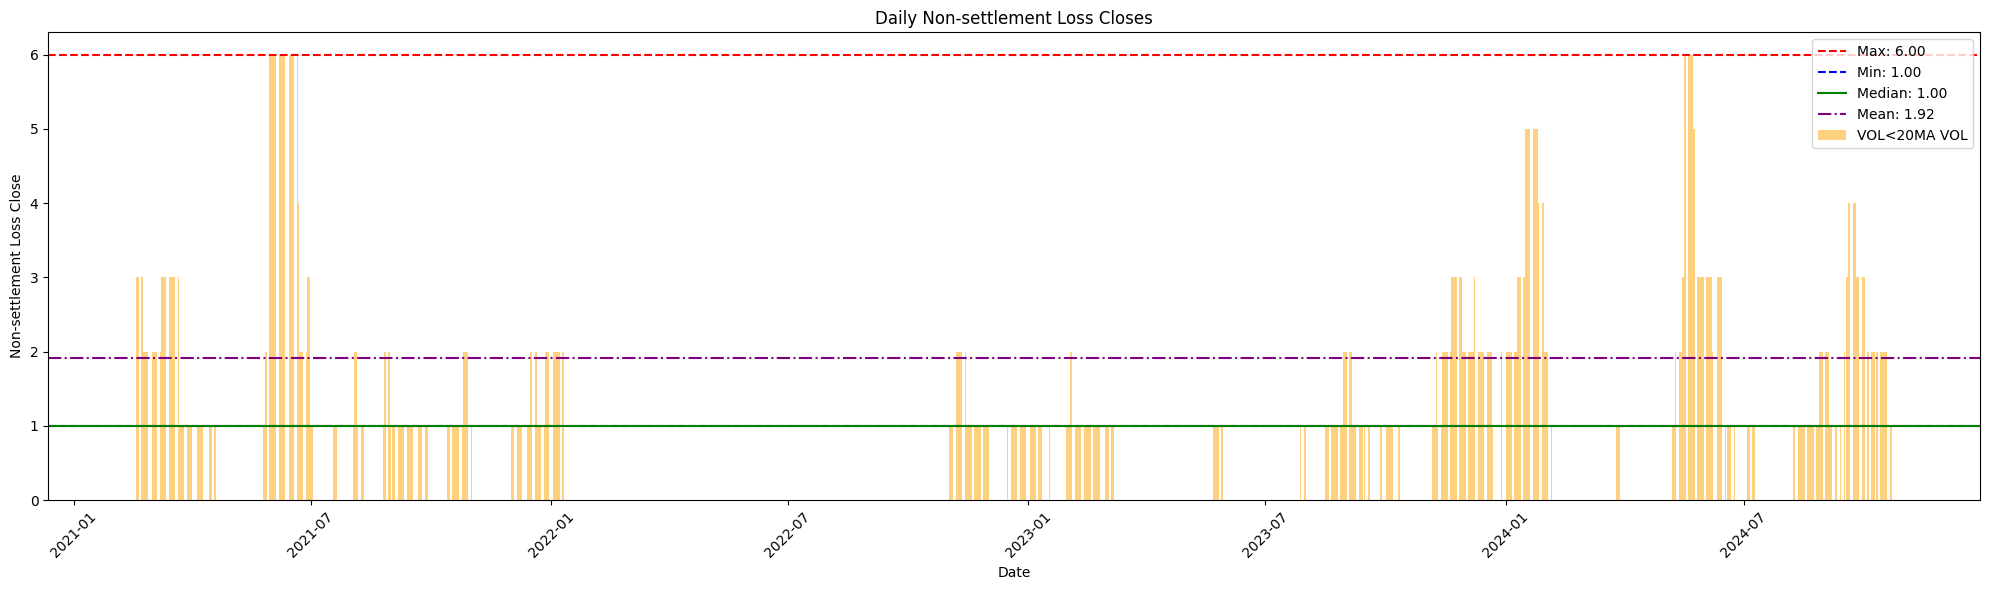

In [107]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 6))

# Plot the first bar chart
# plt.bar(everyday_list.index, everyday_list['size'], width=1, label='VOL>20MA VOL', alpha=0.5)

# Plot the second bar chart on top with a different color and alpha for transparency
plt.bar(everyday_list2.index, everyday_list2['size'], width=1, label='VOL<20MA VOL', alpha=0.5, color='orange')

# Add horizontal lines for max, min, mean, and median of everyday_list
plt.axhline(everyday_list2['size'].max(), color='red', linestyle='--', label=f'Max: {everyday_list2["size"].max():.2f}')
plt.axhline(everyday_list2['size'].min(), color='blue', linestyle='--', label=f'Min: {everyday_list2["size"].min():.2f}')
plt.axhline(everyday_list2['size'].median(), color='green', linestyle='-', label=f'Median: {everyday_list2["size"].median():.2f}')
plt.axhline(everyday_list2['size'].mean(), color='purple', linestyle='-.', label=f'Mean: {everyday_list2["size"].mean():.2f}')

# Add titles and labels
plt.title('Daily Non-settlement Loss Closes')
plt.xlabel('Date')
plt.ylabel('Non-settlement Loss Close')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


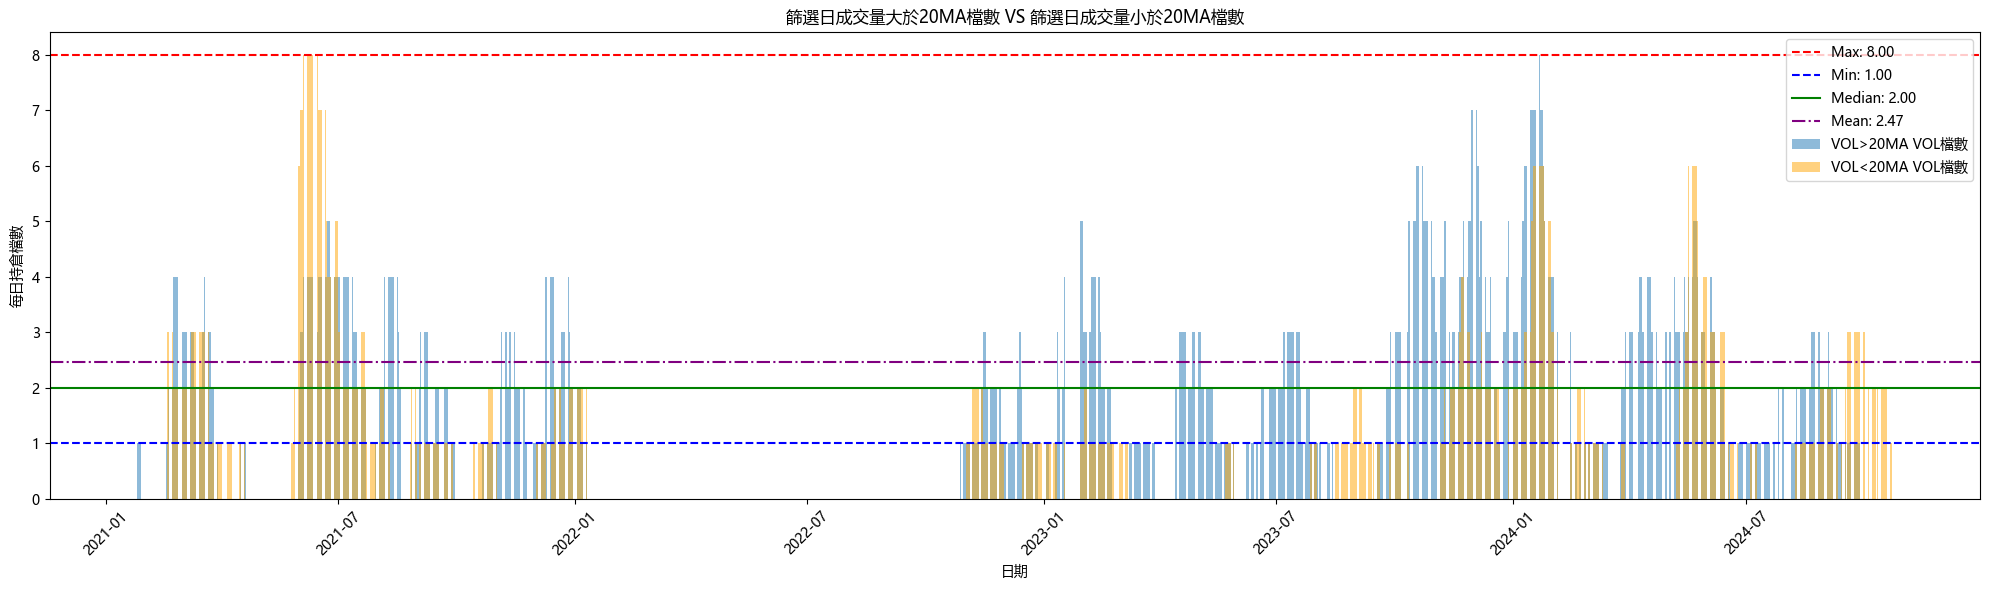

In [223]:
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# Set the figure size
plt.figure(figsize=(20, 6))

# Plot the first bar chart
plt.bar(everyday_list.index, everyday_list['size'], width=1, label='VOL>20MA VOL檔數', alpha=0.5)

# Plot the second bar chart on top with a different color and alpha for transparency
plt.bar(everyday_list2.index, everyday_list2['size'], width=1, label='VOL<20MA VOL檔數', alpha=0.5, color='orange')

# Add horizontal lines for max, min, mean, and median of everyday_list
plt.axhline(everyday_list['size'].max(), color='red', linestyle='--', label=f'Max: {everyday_list["size"].max():.2f}')
plt.axhline(everyday_list['size'].min(), color='blue', linestyle='--', label=f'Min: {everyday_list["size"].min():.2f}')
plt.axhline(everyday_list['size'].median(), color='green', linestyle='-', label=f'Median: {everyday_list["size"].median():.2f}')
plt.axhline(everyday_list['size'].mean(), color='purple', linestyle='-.', label=f'Mean: {everyday_list["size"].mean():.2f}')

# Add titles and labels
plt.title('篩選日成交量大於20MA檔數 VS 篩選日成交量小於20MA檔數')
plt.xlabel('日期')
plt.ylabel('每日持倉檔數')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


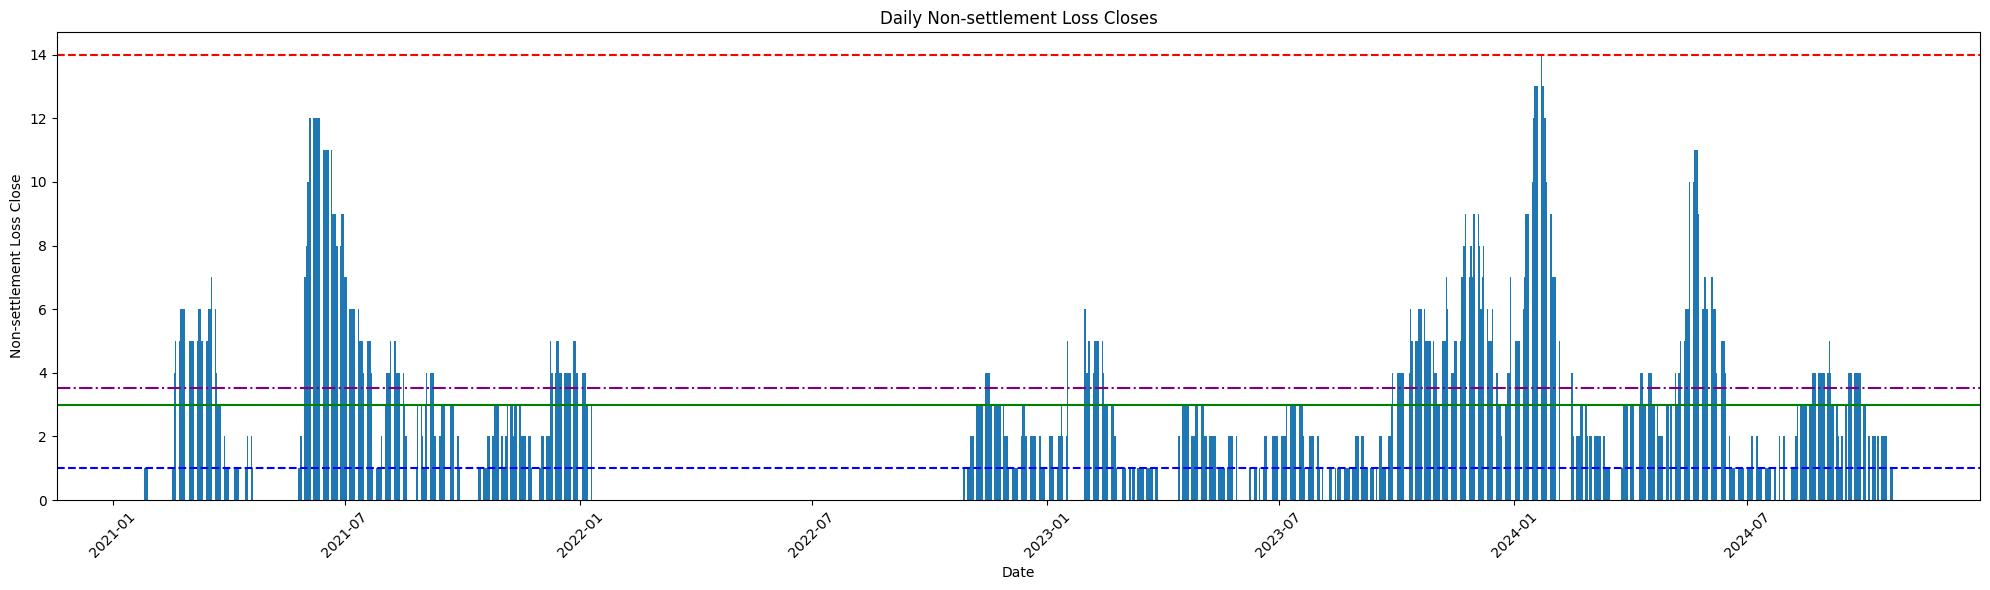

In [123]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 6))

# Plot a bar chart with dates on the x-axis and values on the y-axis
plt.bar(everyday_list.index, everyday_list['size'], width=1)

# Add horizontal lines for max, min, mean, and median
plt.axhline(everyday_list['size'].max(), color='red', linestyle='--', label=f'Max: {everyday_list['size'].max():.2f}')
plt.axhline(everyday_list['size'].min(), color='blue', linestyle='--', label=f'Min: {everyday_list['size'].min():.2f}')
plt.axhline(everyday_list['size'].median(), color='green', linestyle='-', label=f'Median: {everyday_list['size'].median():.2f}')
plt.axhline(everyday_list['size'].mean(), color='purple', linestyle='-.', label=f'Mean: {everyday_list['size'].mean():.2f}')

# Add titles and labels
plt.title('Daily Non-settlement Loss Closes')
plt.xlabel('Date')
plt.ylabel('Non-settlement Loss Close')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [274]:
earn_date_list = earn_date_list.groupby('hold_day')['need_price'].sum()
earn_date_list.columns = ['buy_date', 'need_price']
earn_date_list = earn_date_list.to_frame(name='need_price')
earn_date_list.groupby('hold_day')['need_price'].sum().mean()

1048.775278810409

In [ ]:


earn_date_list[earn_date_list['hold_day'].isin(earn_date_list2[earn_date_list2['size'] == 1].index.tolist())]

In [289]:
earn_date_list2 = earn_date_list.groupby('hold_day').size()

earn_date_list2.columns = ['buy_date', 'size','earn_money']
earn_date_list2 = earn_date_list2.to_frame(name='size')
earn_date_list2[earn_date_list2['size'] == 1].index

# earn_date_list[earn_date_list2[earn_date_list2['size'] == 1].index]

earn_date_list[earn_date_list['hold_day'].isin(earn_date_list2[earn_date_list2['size'] == 1].index.tolist())]

,hold_day,stock_id,need_price,earn_money
0,2021-01-26,2028,212.5,-8.5000
1,2021-01-27,2028,212.5,-8.5000
2,2021-01-28,2028,212.5,-8.5000
3,2021-02-17,6224,354.0,-1.4868
104,2021-04-15,8099,300.0,-12.0000
...,...,...,...,...
1701,2024-08-08,2363,337.5,4.9950
1738,2024-09-04,3450,367.5,136.4895
1739,2024-09-05,3450,367.5,136.4895
1740,2024-09-06,3450,367.5,136.4895


In [259]:
# 調整購買比重

def weighted_price(price):
    if price < 20:
        return price * 20
    
    elif 20 <= price < 40:
        return price * 10  
    
    elif 40 <= price < 50:
        return price * 8  
    
    elif 50 <= price < 65:
        return price * 6    
      
    elif 65 <= price < 80:
        return price * 5    
    
    elif 80 <= price < 100:
        return price * 4

    elif 100 <= price < 130:
        return price * 3  
    
    elif 130 <= price < 200:
        return price * 2  
    
    elif 200 <= price :
        return price * 1  

earn_date_list['weighted_price'] = earn_date_list['明天收盤價'].apply(weighted_price)
earn_date_list['weighted_earn_price'] = earn_date_list['weighted_price'] * earn_date_list['earn_mix'] / 100

# tt = collected_data_day[['證券名稱','證券代號','明天收盤價','buy_date','sell_date', 'daily_return','earn_nonsetloss_close','real_hold_day']]
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']
earn_date_list = pd.DataFrame(columns=['hold_day','stock_id', 'daily_return','need_price'])

for i in range(len(earn_date_list)):
    stock_info = earn_date_list.iloc[i]
    buy_date = stock_info['buy_date']
    sell_date = stock_info['sell_date']
    need_price = stock_info['weighted_price'] # 加權過後的明日收盤價

    # not_sl_sell_date = stock_info['not_sl_sell_date']

    stock_id = stock_info['證券代號']
    daily_return = stock_info['daily_return']
    
    Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

    for day in Date_list:
        temp_df = pd.DataFrame({
            'hold_day': [day],
            'stock_id' : [stock_id],
            'daily_return': [daily_return],
            'need_price':[need_price]
        })

        # 删除全为NA的列，避免可能出现的警告
        temp_df.dropna(axis=1, how='all', inplace=True)
        if not temp_df.empty:
            earn_date_list = pd.concat([earn_date_list, temp_df], ignore_index=True)

print(earn_date_list.groupby('hold_day')['need_price'].sum().max())
print(earn_date_list['weighted_earn_price'].cumsum().iloc[-1])




3825.6
2148.7847899999992


解釋可以看這個
https://www.aicoin.com/zh-Hant/article/112540

Cumulative returns 是用 cumulative_returns = (1 + earn_date_list[calculate_column]).cumprod() - 1 去算的


In [66]:
calculate_column = 'earn_nonsetloss_close'
earn_date_list['buy_date'] = pd.to_datetime(earn_date_list['buy_date'])

earn_date_list = earn_date_list[['buy_date', calculate_column]]
earn_date_list = earn_date_list.groupby('buy_date')[calculate_column].sum()

earn_date_list.columns = ['buy_date', calculate_column]
earn_date_list = earn_date_list.to_frame(name=calculate_column)
earn_date_list[calculate_column] = earn_date_list[calculate_column] / 100
earn_date_list[calculate_column].cumsum()

earn_date_list[calculate_column] / earn_date_list['real_hold_day']



0      6.666667
1      0.877857
2      0.958333
3        6.0225
4           1.7
         ...   
185   -0.397895
186      1.3265
187        -2.5
188     -2.4925
189   -0.440667
Length: 190, dtype: object

In [64]:
print(earn_date_list[(earn_date_list['select_day'] > '2021-01-01') & (earn_date_list['select_day'] < '2021-12-31')]['earn_mix'].mean())
print(earn_date_list[(earn_date_list['select_day'] > '2022-01-01') & (earn_date_list['select_day'] < '2022-12-31')]['earn_mix'].mean())
print(earn_date_list[(earn_date_list['select_day'] > '2023-01-01') & (earn_date_list['select_day'] < '2023-12-31')]['earn_mix'].mean())
print(earn_date_list[(earn_date_list['select_day'] > '2024-01-01') & (earn_date_list['select_day'] < '2024-12-31')]['earn_mix'].mean())

16.387857142857143
0.18000000000000002
12.78875
9.887142857142859


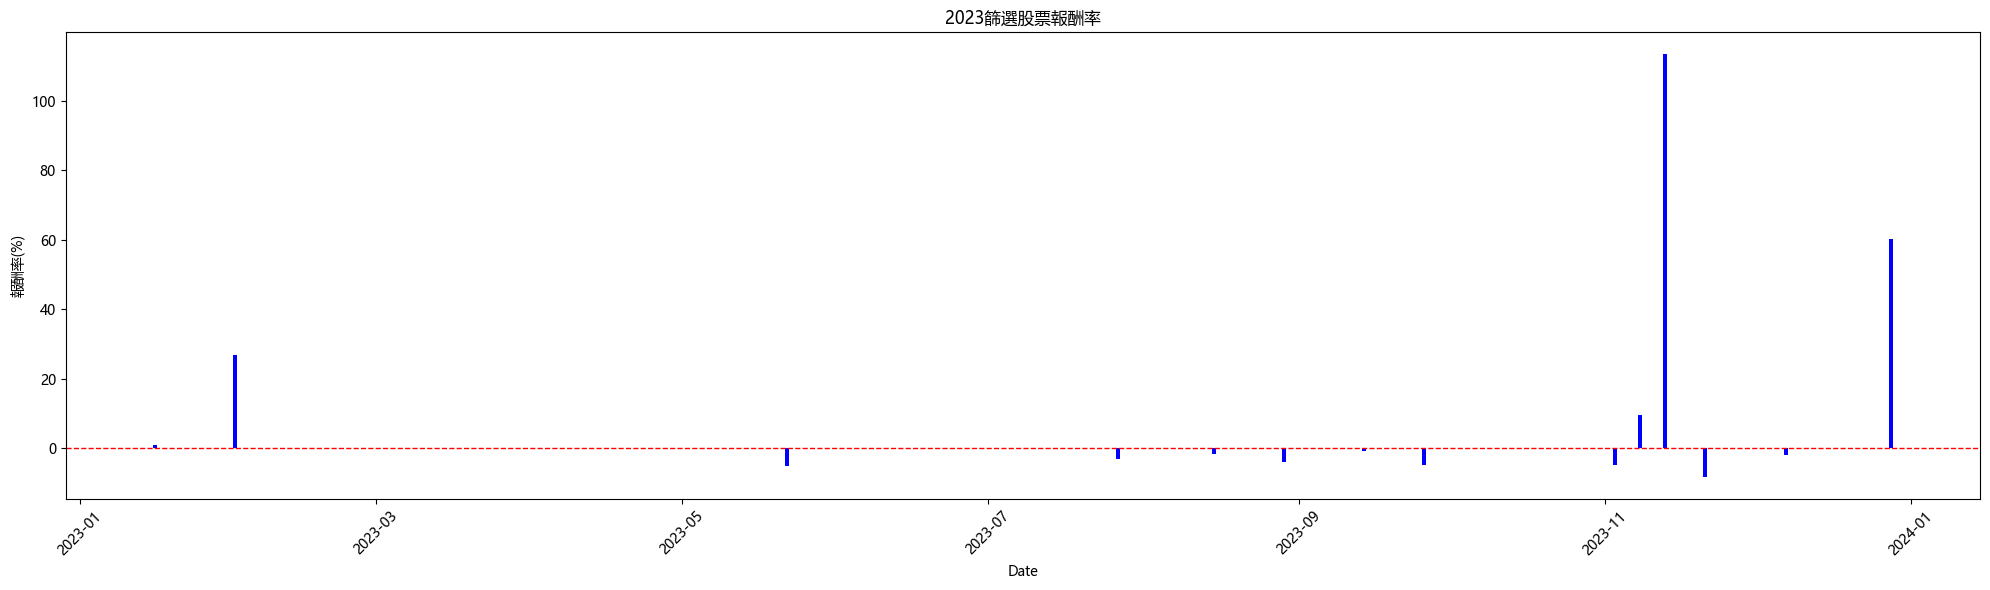

In [117]:
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 假設 earn_date_list 是一個包含 select_day 和 earn_mix 的 DataFrame
# 並且 select_day 已經是 datetime 格式
# 篩選出 2023 年的資料
filtered_data = earn_date_list[(earn_date_list['select_day'] > '2023-01-01') & 
                               (earn_date_list['select_day'] < '2023-12-31')]

# 繪製 earn_mix 的長條圖
plt.figure(figsize=(20, 6))
plt.bar(filtered_data['select_day'], filtered_data['earn_mix'], color='blue')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('報酬率(%)')
plt.title('2023篩選股票報酬率')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [115]:
earn_date_list[(earn_date_list['select_day'] > '2023-01-01') & (earn_date_list['select_day'] < '2023-12-31')]

,證券代號,證券名稱,select_day,開盤價,收盤價,明天收盤價,明天開盤價,後天收盤價,後天開盤價,X天收盤價,...,BMFE,real_hold_day,not_sl_sell_date,VOL,VOL5,VOL10,VOL20,VOL60,weighted_price,weighted_earn_price
31,2929,淘帝-KY,2023-01-16,16.85,17.40,17.25,17.40,18.95,17.6,16.75,...,20.58,6,2023-03-01,1630,1603.2,1808.2,2837.30,1741.316667,345.0,3.00150
32,1342,八貫,2023-02-01,121.00,131.00,127.00,135.00,124.50,127.0,161.00,...,0.00,22,2023-03-07,2408,1365.6,1584.2,2536.40,1909.750000,381.0,101.99370
33,4541,晟田,2023-05-22,42.50,46.10,45.75,47.00,46.50,46.0,44.50,...,1.64,5,2023-06-21,4614,3203.0,3614.3,6333.25,3810.633333,366.0,-19.21500
34,2427,三商電,2023-07-27,27.00,28.95,27.55,29.60,26.80,27.7,22.20,...,0.00,3,2023-08-29,3108,2511.6,2907.6,6084.10,5477.966667,275.5,-8.51295
35,8210,勤誠,2023-08-15,193.00,201.50,215.50,199.00,223.00,211.5,214.50,...,8.58,15,2023-09-14,3685,9071.6,6020.2,7068.45,8071.566667,215.5,-3.49110
36,3257,虹冠電,2023-08-29,74.00,80.80,81.20,81.40,81.10,80.5,73.90,...,11.70,11,2023-09-28,2515,1247.8,1285.1,2653.80,1430.983333,324.8,-12.79712
37,3362,先進光,2023-09-14,147.50,157.50,155.00,159.00,152.00,153.0,136.00,...,0.00,3,2023-10-19,3099,2886.6,2566.1,3289.65,5333.616667,310.0,-3.00700
38,1471,首利,2023-09-26,19.20,20.30,19.60,20.00,21.10,19.7,17.95,...,8.16,9,2023-10-31,3523,1984.8,2849.0,4628.40,4009.483333,392.0,-19.01200
39,6187,萬潤,2023-11-03,125.00,130.00,131.50,131.00,129.50,133.0,127.50,...,0.00,4,2023-12-05,3695,1995.4,3321.1,4472.30,3096.600000,263.0,-12.99220
40,3276,宇環,2023-11-08,23.10,23.90,23.35,23.85,23.85,22.8,25.90,...,2.14,22,2023-12-08,1274,1240.0,3081.8,3080.35,2008.266667,233.5,22.50940


In [105]:
remove_df  = exit_stock_list[['select_day', '證券代號']]
# 使用 merge 並標記要移除的資料
merged_df = earn_date_list.merge(remove_df, on=['select_day', '證券代號'], how='left', indicator=True)
merged_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

merged_df

,證券代號,證券名稱,select_day,開盤價,收盤價,明天收盤價,明天開盤價,後天收盤價,後天開盤價,X天收盤價,...,BMFE,real_hold_day,not_sl_sell_date,VOL,VOL5,VOL10,VOL20,VOL60,weighted_price,weighted_earn_price
0,3092,鴻碩,2021-02-17,62.1,66.8,71.30,67.80,73.10,71.0,73.10,...,4.91,22,2021-03-22,3596,1677.0,2290.0,5720.50,4190.266667,356.5,8.98380
1,6129,普誠,2021-02-17,16.4,16.5,17.60,16.50,17.50,17.4,45.00,...,0.00,22,2021-03-22,2054,1193.6,1683.0,2179.40,2315.516667,352.0,547.99360
2,6284,佳邦,2021-02-17,72.3,77.1,76.50,76.90,74.70,76.7,80.30,...,2.75,3,2021-03-22,3872,2687.6,3121.0,4530.10,5912.816667,382.5,-2.48625
3,6237,驊訊,2021-03-08,83.4,90.3,88.50,89.50,92.50,93.0,171.00,...,4.52,22,2021-04-09,4962,3499.6,4396.6,6239.25,7314.216667,354.0,329.99880
4,8099,大世科,2021-04-14,49.5,52.3,50.00,52.50,50.70,50.2,35.30,...,1.40,3,2021-05-17,1548,1106.8,1471.2,1558.75,1103.316667,300.0,6.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,4534,慶騰,2024-08-27,25.3,27.8,28.60,27.75,27.60,28.0,24.55,...,6.64,10,2024-09-27,1315,1509.2,2520.6,2057.15,1921.766667,286.0,-25.99740
64,3167,大量,2024-09-12,79.3,85.3,90.30,87.00,92.50,91.9,141.50,...,2.44,22,2024-10-18,3070,2198.8,2926.0,5897.90,4218.116667,361.2,204.80040
65,8028,昇陽半導體,2024-09-13,120.0,125.5,128.00,125.50,124.00,127.5,135.00,...,1.95,11,2024-10-21,10888,6903.0,7066.7,17026.85,16416.683333,384.0,-5.99040
66,6535,順藥,2024-09-16,238.0,256.5,256.50,254.00,255.00,256.5,317.50,...,0.00,22,2024-10-22,1143,655.0,835.0,1250.75,1825.066667,256.5,60.99570


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\empyrical\stats.py:1424: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(np.percentile(returns, 95)) / np.abs(np.percentile(returns, 5))


Start date,2021-01-04
End date,2024-09-30
Total months,43
,Backtest
Annual return,36.131%
Cumulative returns,204.231%
Annual volatility,29.184%
Sharpe ratio,1.18
Calmar ratio,4.19
Stability,0.64
Max drawdown,-8.62%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.62,2021-08-04,2022-11-14,2023-12-22,623
1,5.81,2024-06-14,2024-09-24,NaT,NaN
2,2.89,2021-06-18,2021-06-22,2021-06-30,9
3,2.49,2024-05-22,2024-05-31,2024-06-06,12
4,1.06,2024-01-24,2024-01-25,2024-01-30,5


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


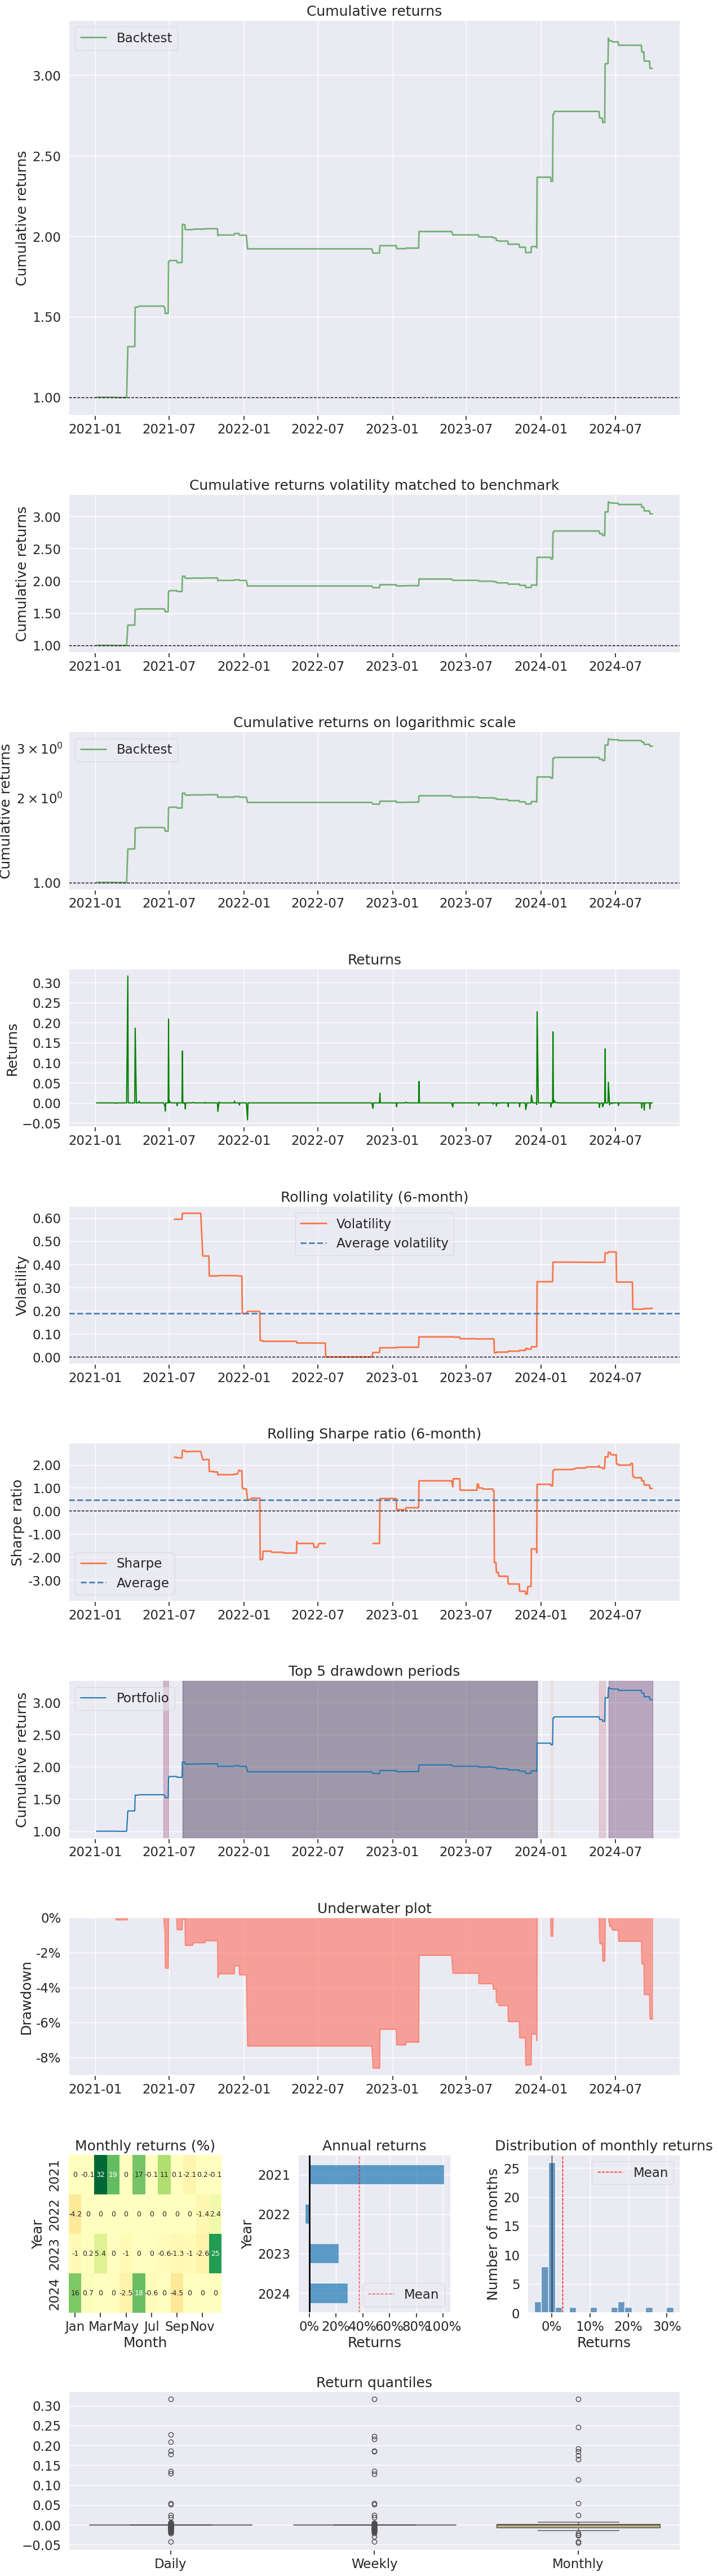

In [82]:

# 其他時間補0
Date_list = stock_2330[(stock_2330['Date'] >= '2021-01-01') & (stock_2330['Date'] <= '2024-09-30')]['Date']

earn_price_list = pd.DataFrame(columns=['Date','earn_price'])

for day in Date_list:

    earn_price = 1000 * merged_df[merged_df['sell_date'] == day]['earn_mix'].sum()

    temp_df = pd.DataFrame({
        'Date': [day],
        'earn_price':[earn_price]
    })

    # 删除全为NA的列，避免可能出现的警告
    temp_df.dropna(axis=1, how='all', inplace=True)
    if not temp_df.empty:
        earn_price_list = pd.concat([earn_price_list, temp_df], ignore_index=True)

earn_price_list.loc[earn_price_list['earn_price'] != 0, 'earn_price'] /= 500000


earn_price_list = earn_price_list.groupby('Date')['earn_price'].sum()

earn_price_list.columns = ['Date', 'earn_price']
earn_price_list = earn_price_list.to_frame(name='earn_price')
earn_price_list

earn_price_list['earn_price'] = pd.to_numeric(earn_price_list['earn_price'], errors='coerce')
import pyfolio as pf
pf.create_returns_tear_sheet( earn_price_list['earn_price'] )

In [91]:
calculate_column = 'earn_nonsetloss_close'
earn_date_list['buy_date'] = pd.to_datetime(earn_date_list['buy_date'])
# 為了pyfolio 要改成每日收益率
earn_date_list['daily_return'] = earn_date_list[calculate_column] / earn_date_list['real_hold_day']

earn_date_list = earn_date_list[['buy_date', 'daily_return']]
earn_date_list = earn_date_list.groupby('buy_date')['daily_return'].sum()

earn_date_list.columns = ['buy_date', 'daily_return']
earn_date_list = earn_date_list.to_frame(name='daily_return')

# earn_date_list.set_index(['buy_date'], inplace=True)


import pyfolio as pf
earn_date_list['daily_return'] = earn_date_list['daily_return'] / 100
earn_date_list['daily_return'] = pd.to_numeric(earn_date_list['daily_return'], errors='coerce')
#处理好的收益数据
# returns = stock_pf_first['earn_mix'].tz_localize('UTC')
# pf.create_returns_tear_sheet( earn_date_list['daily_return'] )

sortino_ratio = pf.timeseries.sortino_ratio(earn_date_list['daily_return'])
max_drawdown = pf.timeseries.max_drawdown(earn_date_list['daily_return'])
annual_return = pf.timeseries.annual_return(earn_date_list['daily_return'])

sortino_ratio * annual_return / abs(max_drawdown)


C:\Users\USER\AppData\Local\Temp\ipykernel_25660\3592521947.py:22: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  sortino_ratio = pf.timeseries.sortino_ratio(earn_date_list['daily_return'])
C:\Users\USER\AppData\Local\Temp\ipykernel_25660\3592521947.py:23: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  max_drawdown = pf.timeseries.max_drawdown(earn_date_list['daily_return'])
C:\Users\USER\AppData\Local\Temp\ipykernel_25660\3592521947.py:24: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  annual_return = pf.timeseries.annual_return(earn_date_list['daily_return'])


142.73969990897547

In [213]:


stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']

calculate_column = 'earn_nonsetloss_close'
calculate_column = 'earn_mix'

earn_date_list['buy_date'] = pd.to_datetime(earn_date_list['buy_date'])
# 為了pyfolio 要改成每日收益率
earn_date_list['daily_return'] = earn_date_list[calculate_column] / earn_date_list['real_hold_day']

earn_date_list = pd.DataFrame(columns=['hold_day','stock_id', 'daily_return','price'])

for i in range(len(earn_date_list)):
    stock_info = earn_date_list.iloc[i]
    buy_date = stock_info['buy_date']

    sell_date = stock_info['sell_date']
    price = stock_info['收盤價']

    # not_sl_sell_date = stock_info['not_sl_sell_date']

    stock_id = stock_info['證券代號']
    daily_return = stock_info['daily_return']
    
    Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

    for day in Date_list:
        result_df = pd.DataFrame({
            'hold_day': [day],
            'stock_id' : [stock_id],
            'daily_return': [daily_return],
            'price':[price]
        })

        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)
        if not result_df.empty:
            earn_date_list = pd.concat([earn_date_list, result_df], ignore_index=True)


earn_date_list_group = earn_date_list.groupby('hold_day')['daily_return'].sum()

earn_date_list_group.columns = ['hold_day', 'daily_return']
earn_date_list_group = earn_date_list_group.to_frame(name='daily_return')

# earn_date_list.set_index(['buy_date'], inplace=True)

import pyfolio as pf
earn_date_list_group['daily_return'] = pd.to_numeric(earn_date_list_group['daily_return'], errors='coerce')
earn_date_list_group['daily_return'] = earn_date_list_group['daily_return'] / 100

#处理好的收益数据
# returns = stock_pf_first['earn_mix'].tz_localize('UTC')

# pf.create_returns_tear_sheet( earn_date_list_group['daily_return'] )

# sortino_ratio = pf.timeseries.sortino_ratio(earn_date_list_group['daily_return'])
# max_drawdown = pf.timeseries.max_drawdown(earn_date_list_group['daily_return'])
# annual_return = pf.timeseries.annual_return(earn_date_list_group['daily_return'])

# sortino_ratio * annual_return / abs(max_drawdown)


In [233]:
tt = earn_date_list[['證券名稱','證券代號','收盤價','buy_date','sell_date', 'daily_return','earn_nonsetloss_close','real_hold_day']]

earn_date_list_group['daily_return'].cumsum()

earn_date_list[earn_date_list['hold_day'] > '2021-06-01']

tt['buy_date'] = pd.to_datetime(tt['buy_date'])
tt[tt['buy_date'] > '2021-05-20'].head(50)


def weighted_price(price):
    if price < 50:
        return price * 8
    elif 50 <= price <= 100:
        return price * 4
    elif 100 <= price <= 200:
        return price * 2  # 假設超過 50 的價格權重為 3，可以根據需求調整
    elif 200 <= price :
        return price * 1  # 假設超過 50 的價格權重為 3，可以根據需求調整    

earn_date_list['weighted_price'] = earn_date_list['price'].apply(weighted_price)


k_group_columns = earn_date_list.groupby('hold_day')['weighted_price'].sum()
# k_group_columns.max()

k_group_columns.columns = ['hold_day', 'total_price']
k_group_columns = k_group_columns.to_frame(name='total_price')
# k_group_columns[k_group_columns['total_price'] == 1797.75]

# tt[tt['收盤價'] > 320]

tt['buy_date'] = pd.to_datetime(tt['buy_date'])
earn_date_list[earn_date_list['hold_day'] == '2024-01-17']


k_group_columns.max()


C:\Users\USER\AppData\Local\Temp\ipykernel_25660\3619059570.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['buy_date'] = pd.to_datetime(tt['buy_date'])
C:\Users\USER\AppData\Local\Temp\ipykernel_25660\3619059570.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['buy_date'] = pd.to_datetime(tt['buy_date'])


total_price    3057.4
dtype: float64

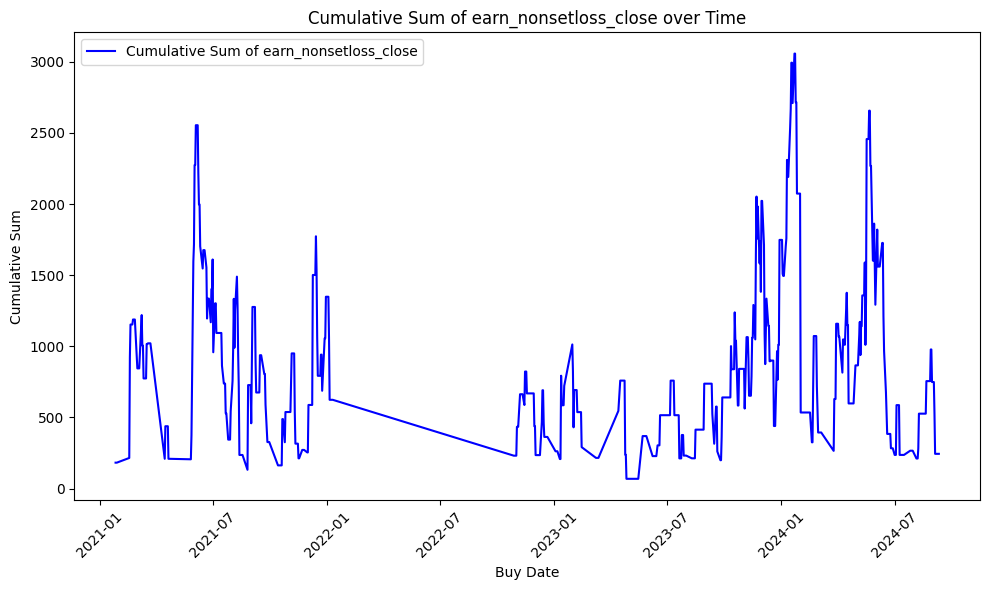

In [232]:
import matplotlib.pyplot as plt

# 累計和數據
cumulative_sum = earn_date_list['earn_nonsetloss_close'].cumsum()

# 繪圖
plt.figure(figsize=(10, 6))
plt.plot(k_group_columns.index, k_group_columns['total_price'], label='Cumulative Sum of earn_nonsetloss_close', color='b')

# 標題和軸標籤
plt.title('Cumulative Sum of earn_nonsetloss_close over Time')
plt.xlabel('Buy Date')
plt.ylabel('Cumulative Sum')

# 格式化 x 軸日期顯示
plt.xticks(rotation=45)

# 顯示圖例
plt.legend()

# 顯示圖表
plt.tight_layout()
plt.show()

In [143]:

earn_date_list['stock_id'] = earn_date_list['stock_id'].astype(str)
earn_date_list[earn_date_list['hold_day'] == '2021-02-18']



,hold_day,stock_id,daily_return
4,2021-02-18,6224,0.877857
17,2021-02-18,3092,0.958333
29,2021-02-18,6129,6.022500
49,2021-02-18,6284,1.700000


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


Start date,2020-01-02
End date,2020-10-15
Total months,9
,Backtest
Annual return,182172.076%
Cumulative returns,28639.517%
Annual volatility,368.592%
Sharpe ratio,3.47
Calmar ratio,2099.96
Stability,0.69
Max drawdown,-86.75%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,86.75,2020-03-02,2020-04-21,2020-07-07,92
1,65.57,2020-08-17,2020-08-28,2020-09-11,20
2,63.45,2020-01-15,2020-02-03,2020-02-10,19
3,63.36,2020-07-08,2020-07-27,2020-08-17,29
4,58.06,2020-09-21,2020-10-15,NaT,NaN


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


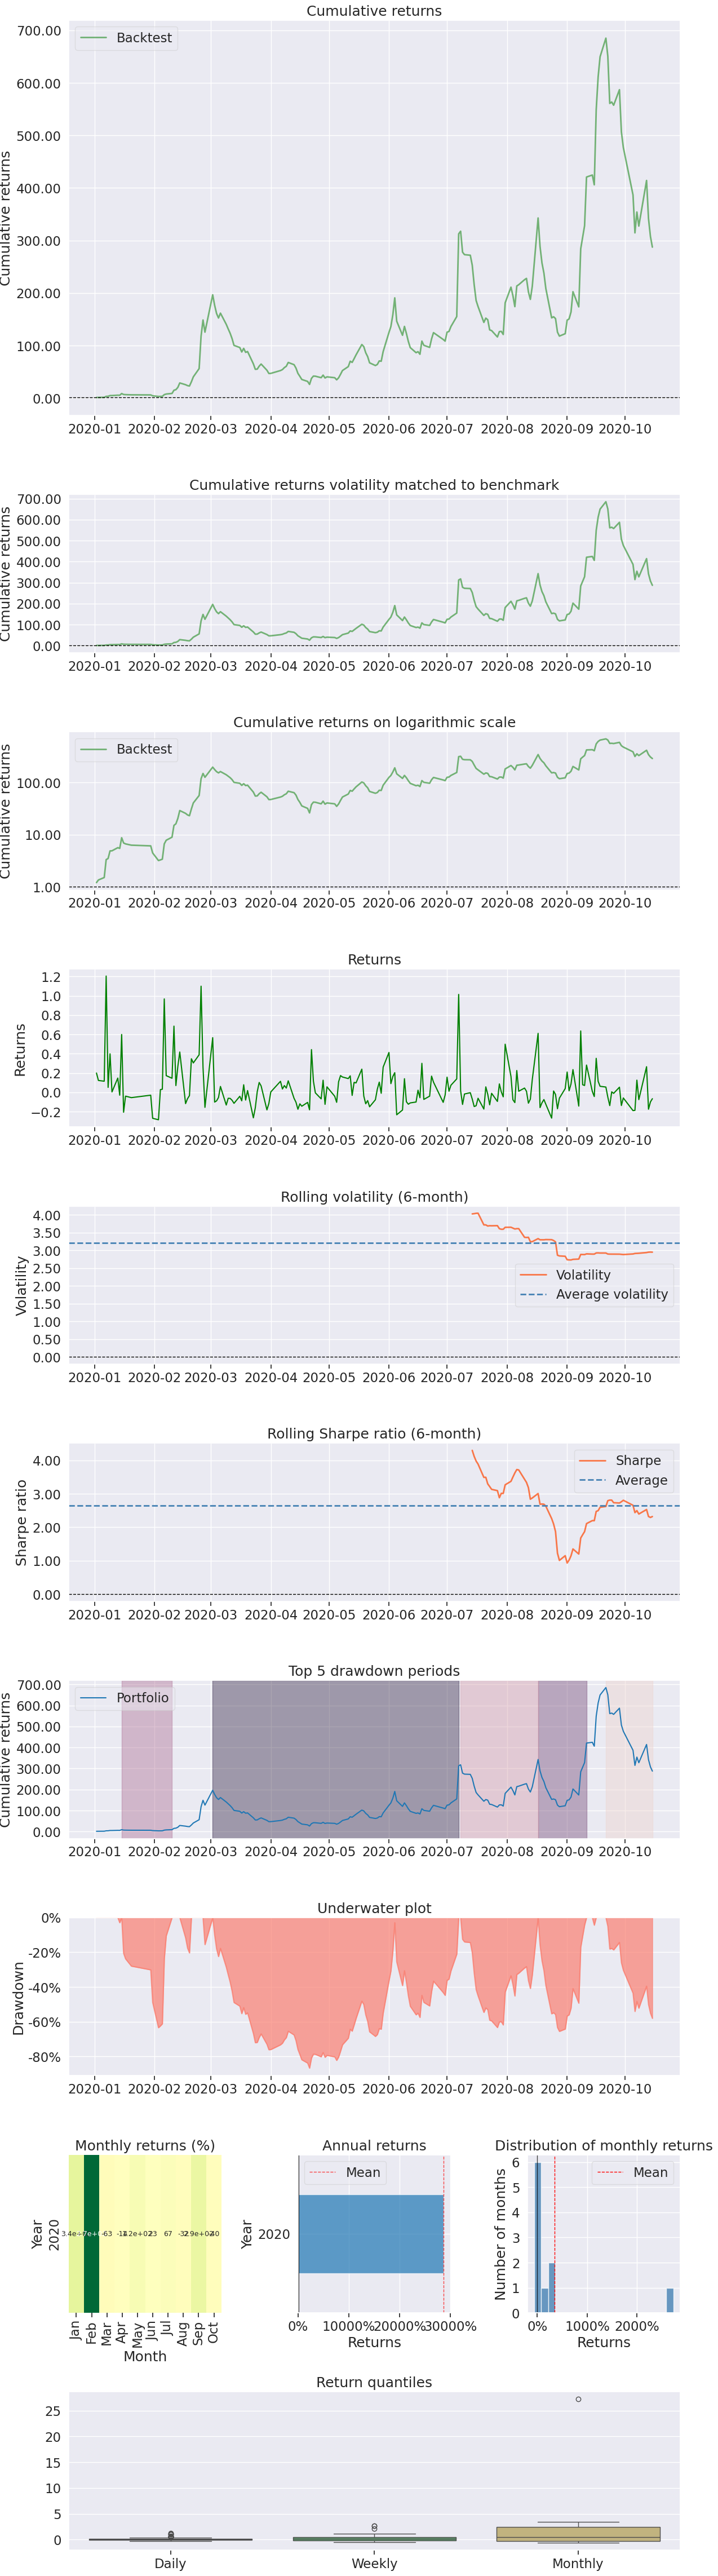

In [8]:
calculate_column = 'earn_nonsetloss_close'

earn_date_list = pd.DataFrame(columns=['Date',calculate_column])
earn_date_list['buy_date'] = pd.to_datetime(earn_date_list['buy_date'])
for i in range(len(earn_date_list)):
    earn2 = earn_date_list[calculate_column].iloc[i]
    
    Date = stock_df_raw[stock_df_raw['證券代號'] == '2330']['Date'].iloc[i]

    result_df = pd.DataFrame({
        'Date': [Date],
        calculate_column: [earn2]
    })

    # 删除全为NA的列，避免可能出现的警告
    result_df.dropna(axis=1, how='all', inplace=True)
    if not result_df.empty:
        earn_date_list = pd.concat([earn_date_list, result_df], ignore_index=True)

earn_date_list.set_index(['Date'], inplace=True)

import pyfolio as pf
earn_date_list[calculate_column] = earn_date_list[calculate_column] / 100
#处理好的收益数据
# returns = stock_pf_first['earn_mix'].tz_localize('UTC')
pf.create_returns_tear_sheet( earn_date_list[calculate_column] )




In [10]:
earn_date_list

,證券代號,證券名稱,收盤價,明天收盤價,明天開盤價,X天收盤價,X天開盤價,earn_close,earn_open,earn_mix,...,earn_nonsetloss_open,buy_date,sell_date,RS20,RS60,RS240,loss_type,GMFE,MAE,BMFE
0,2028,威致,22.75,21.25,22.45,25.50,25.30,0.24,-4.00,-4.00,...,12.69,2021-01-26,2021-01-28,57.586207,93.505747,97.586207,2,22.59,-7.76,0.24
1,6224,聚鼎,107.50,118.00,114.50,132.50,138.00,0.42,-0.42,-0.42,...,20.52,2021-02-17,2021-03-09,87.263339,91.508893,90.189329,2,16.95,0.00,13.14
2,3092,鴻碩,66.80,71.30,67.80,79.50,81.40,-2.52,0.00,0.00,...,20.06,2021-02-18,2021-03-08,75.802752,90.309633,91.972477,2,14.31,-2.81,4.91
3,6129,普誠,16.50,17.60,16.50,38.80,33.50,120.45,103.03,120.45,...,103.03,2021-02-18,2021-03-18,58.600917,96.961009,98.050459,1,120.45,-0.57,0.00
4,6284,佳邦,77.10,76.50,76.90,80.40,83.60,2.75,-0.65,-0.65,...,8.71,2021-02-18,2021-02-22,68.807339,94.151376,97.534404,2,10.85,-7.84,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,2363,矽統,70.60,67.50,70.00,62.40,63.10,-0.89,1.48,1.48,...,-9.86,2024-08-08,2024-09-03,98.757428,96.812534,94.759589,2,9.33,-7.56,9.33
186,3450,聯鈞,122.00,122.50,126.00,155.00,161.50,26.53,28.17,26.53,...,28.17,2024-08-09,2024-09-05,58.887088,94.705565,96.542410,1,45.71,0.00,3.67
187,3686,達能,28.60,30.00,28.50,24.75,24.20,-7.17,-6.67,-6.67,...,-15.09,2024-08-21,2024-08-29,62.978953,91.851052,95.358877,2,0.33,-23.33,0.33
188,4534,慶騰,27.80,28.60,27.75,25.75,23.55,-0.35,-6.47,-6.47,...,-15.14,2024-08-28,2024-09-02,81.135135,94.270270,98.162162,2,6.64,-18.01,6.64


Start date,2020-01-02
End date,2020-10-15
Total months,9
,Backtest
Annual return,291179.47%
Cumulative returns,40824.15%
Annual volatility,313.386%
Sharpe ratio,3.84
Calmar ratio,4032.32
Stability,0.84
Max drawdown,-72.211%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,72.21,2020-03-02,2020-04-21,2020-06-04,69
1,53.00,2020-08-17,2020-08-28,2020-09-04,15
2,48.84,2020-07-13,2020-07-27,2020-08-11,22
3,45.56,2020-06-04,2020-06-17,2020-07-07,24
4,44.51,2020-01-17,2020-02-03,2020-02-06,15


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\plotting.py:1407: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



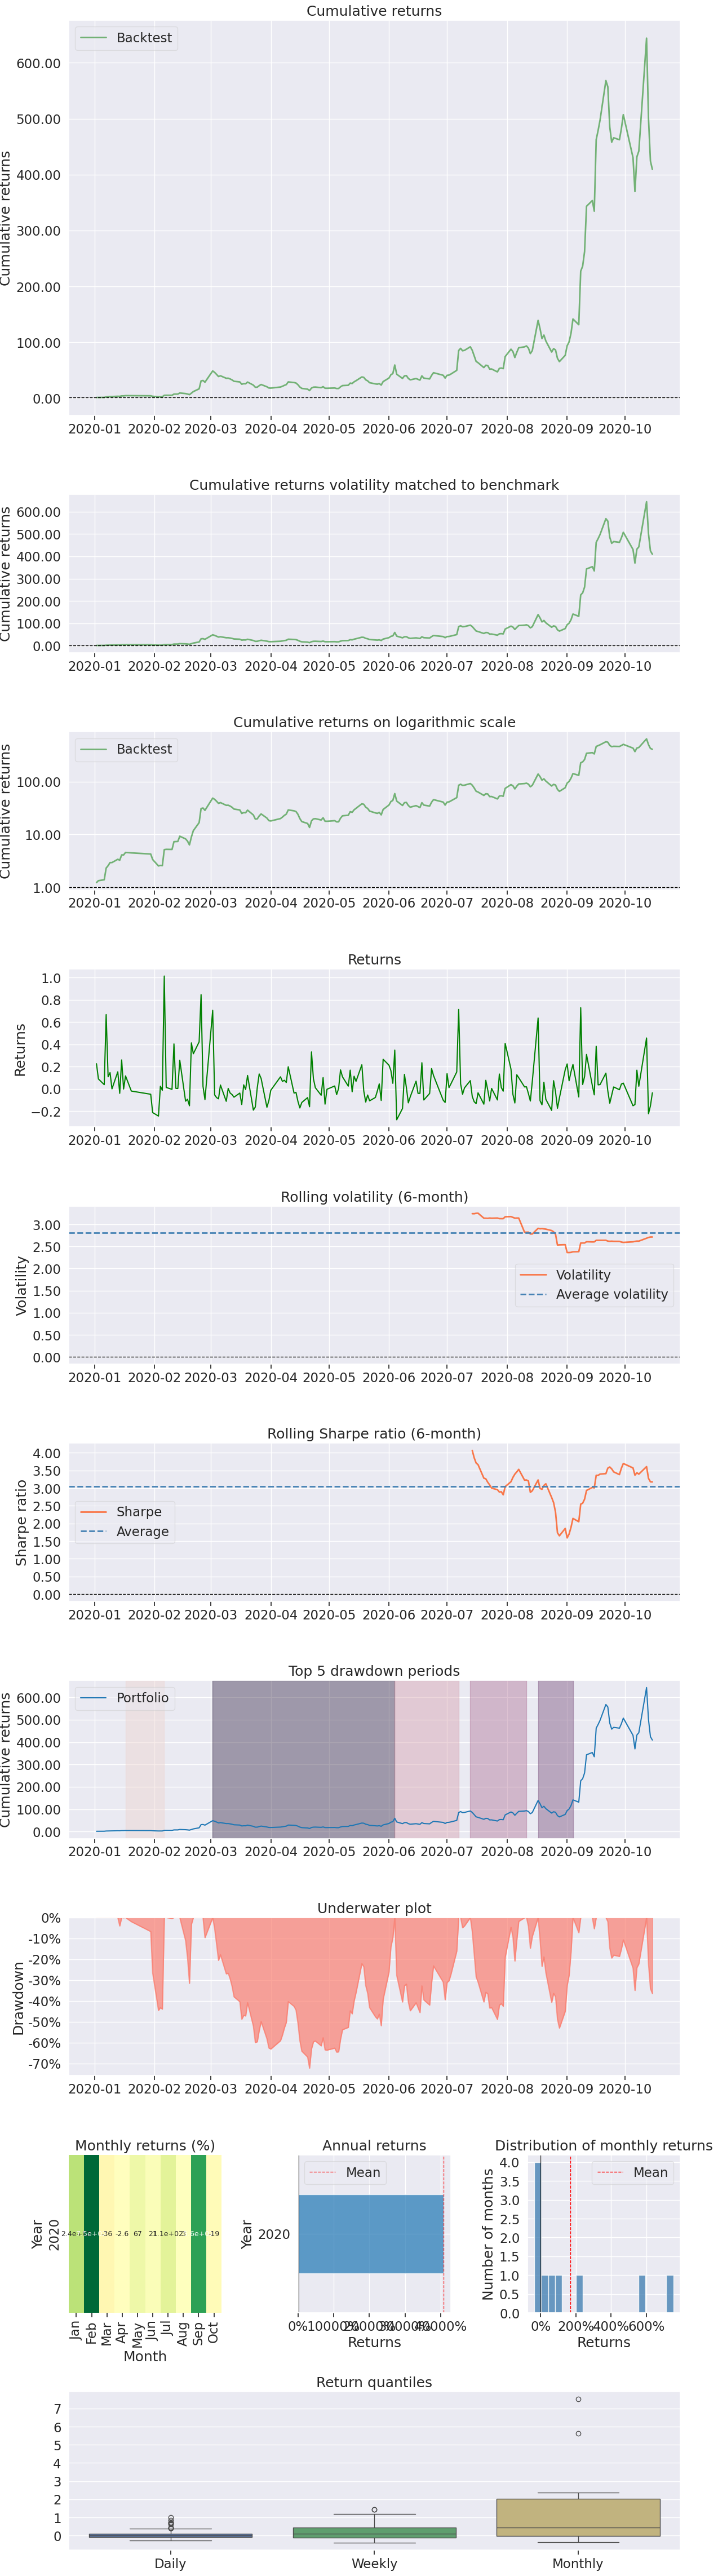

In [83]:
import pyfolio as pf

earn_date_list['earn_nonsetloss_close'] = earn_date_list['earn_nonsetloss_close'] / 100
#处理好的收益数据
# returns = stock_pf_first['earn_mix'].tz_localize('UTC')

pf.create_returns_tear_sheet( earn_date_list['earn_nonsetloss_close'] )

C:\Users\USER\AppData\Local\Temp\ipykernel_20428\4271138391.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Start date,2021-01-26
End date,2024-09-03
Total months,7
,Backtest
Annual return,18582.596%
Cumulative returns,2244.624%
Annual volatility,307.301%
Sharpe ratio,2.96
Calmar ratio,236.86
Stability,0.68
Max drawdown,-78.455%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,78.45,2021-07-05,2021-12-30,2023-11-14,617
1,50.42,2023-11-15,2023-12-15,2024-01-17,46
2,47.41,2024-01-17,2024-03-29,2024-04-29,74
3,44.58,2021-03-09,2021-04-16,2021-05-31,60
4,36.46,2024-08-09,2024-09-03,NaT,NaN


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\plotting.py:1407: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



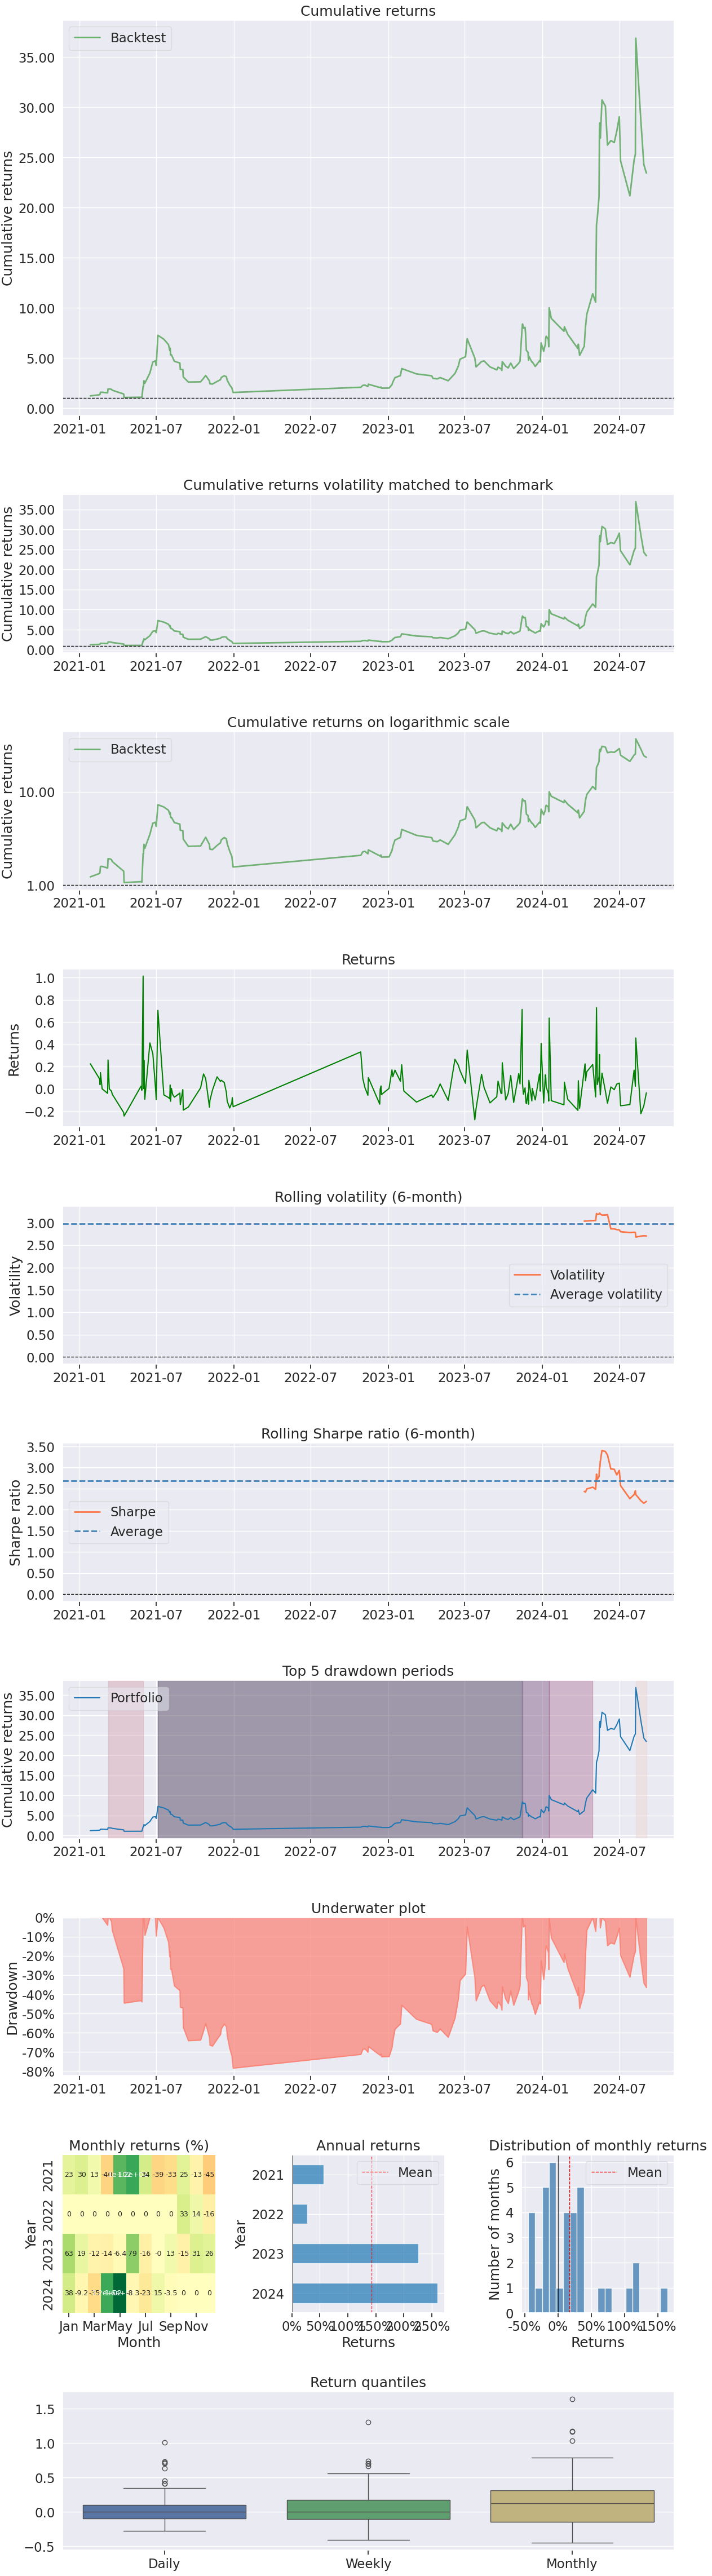

In [78]:
earn_date_list['buy_date'] = pd.to_datetime(earn_date_list['buy_date'])
stock_pf_first = earn_date_list.drop_duplicates(subset='buy_date', keep='first')
# stock_pf_first.set_index(['buy_date'], inplace=True)

# earn_type = 'earn_nonsetloss_close' 
earn_type = 'earn_nonsetloss_close'

import pyfolio as pf

stock_pf_first['buy_date'] = pd.to_datetime(stock_pf_first['buy_date'])
stock_pf_first=stock_pf_first[['buy_date', earn_type]]
stock_pf_first[earn_type] = stock_pf_first[earn_type] / 100
stock_pf_first.set_index('buy_date', inplace=True)
#处理好的收益数据
# returns = stock_pf_first['earn_mix'].tz_localize('UTC')

pf.create_returns_tear_sheet( stock_pf_first[earn_type] )

In [216]:
earn_date_list['MAE'] = abs(earn_date_list['MAE'])
import plotly.express as px

# Creating the scatter plot using plotly.express
fig = px.scatter(earn_date_list, x='MAE', y='BMFE', title='BMFE vs. MAE')

fig.add_shape(
    type='line',
    x0=min(earn_date_list['MAE']), y0=min(earn_date_list['MAE']),
    x1=max(earn_date_list['MAE']), y1=max(earn_date_list['MAE']),
    line=dict(color='red', dash='dash')  # Customize the color and style
)
# Show the plot
fig.show()

In [217]:
import plotly.express as px
import pandas as pd
# Filter data for positive and negative earn2 values
positive_earn2 = earn_date_list[earn_date_list['earn_mix'] > 0]
negative_earn2 = earn_date_list[earn_date_list['earn_mix'] < 0]

# Create bubble chart for positive earn2 (blue)
fig = px.scatter(positive_earn2, 
                 x= positive_earn2['earn_mix'], 
                 y= abs(positive_earn2['BMFE']), 
                 size= positive_earn2['earn_mix'],
                 title="BMFE/Return",  
                 labels={'earn2': 'Return(%)', 'MAE': 'MAE(%)'},
                 size_max=20, 
                 color_discrete_sequence=["blue"])  # Blue for positive earn2

# Add bubble chart for negative earn2 (red)
fig2 = px.scatter(negative_earn2, 
                  x= negative_earn2['earn_mix'], 
                  y= abs(negative_earn2['BMFE']), 
                  size= abs(negative_earn2['earn_mix']),
                  title="BMFE/Return",  
                  size_max=20,
                  color_discrete_sequence=["red"])  # Red for negative earn2

# Combine the two figures (positive + negative)
fig.add_traces(fig2.data)
# Show plot
fig.show()

往不利方向加減碼 下圖大概在MAE 為 5%的時候開始分開 也就是說 虧損>5%之後基本上就容易賠錢，那5%就會是一個判斷的flag

In [218]:
import plotly.express as px
import pandas as pd
# Filter data for positive and negative earn2 values
positive_earn2 = earn_date_list[earn_date_list['earn_mix'] > 0]
negative_earn2 = earn_date_list[earn_date_list['earn_mix'] < 0]


fig = px.histogram(positive_earn2, 
                   x='MAE',  # X-axis is the 'MAE' column
                   title="MAE Count Bar Chart", 
                   labels={'MAE': 'MAE (%)', 'count': 'Count'},
                   nbins=100,
                   color_discrete_sequence=["blue"])  # Customize labels


# Create bubble chart for positive earn2 (blue)
fig2 = px.histogram(negative_earn2, 
                   x='MAE',  # X-axis is the 'MAE' column
                   title="MAE Count Bar Chart", 
                   labels={'MAE': 'MAE (%)', 'count': 'Count'},
                   nbins=100,
                   color_discrete_sequence=["red"])  # Customize labels

# # Add bubble chart for negative earn2 (red)
# fig2 = px.scatter(negative_earn2, 
#                   x= negative_earn2['earn_mix'], 
#                   y= abs(negative_earn2['BMFE']), 
#                   size= abs(negative_earn2['earn_mix']),
#                   title="BMFE/Return",  
#                   size_max=20,
#                   color_discrete_sequence=["red"])  # Red for negative earn2

# Combine the two figures (positive + negative)
fig.add_traces(fig2.data)
# Show plot
fig.show() 

In [98]:
backday = 120
total_backday_df = pd.DataFrame(columns=['XDAY','buyday','證券代號','證券名稱', '收盤價','X天最低收盤價','差距min','差距max', 'earn_mix'])
    
for i in range(len(earn_date_list)):

    df = earn_date_list.iloc[i]
    buyday = df['buy_date']
    close_price = df['收盤價']
    stock_id = df['證券代號']
    earn_mix = df['earn_mix']

    df_his_min_price = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] < buyday )]['收盤價'].rolling(backday).min().iloc[-1]
    df_his_max_price = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] < buyday )]['收盤價'].rolling(backday).max().iloc[-1]

    result_df = pd.DataFrame({
    'XDAY':[backday],
    'buyday':[buyday],
    '證券代號': [stock_id],
    '證券名稱': [df['證券名稱']],
    '收盤價': [close_price],
    'X天最低收盤價': [df_his_min_price],
    '差距min': [close_price/df_his_min_price], 3
    '差距max': [df_his_max_price/ close_price], 1.25
    'earn_mix': [earn_mix]
    })

    # 删除全为NA的列，避免可能出现的警告
    result_df.dropna(axis=1, how='all', inplace=True)

    if not earn_df.empty:
            total_backday_df = pd.concat([total_backday_df, result_df], ignore_index=True) 
total_backday_df

C:\Users\USER\AppData\Local\Temp\ipykernel_15500\1965477156.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  '差距min': [close_price/df_his_min_price],
C:\Users\USER\AppData\Local\Temp\ipykernel_15500\1965477156.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  '差距min': [close_price/df_his_min_price],
C:\Users\USER\AppData\Local\Temp\ipykernel_15500\1965477156.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  '差距min': [close_price/df_his_min_price],


,XDAY,buyday,證券代號,證券名稱,收盤價,X天最低收盤價,差距min,差距max,earn_mix
0,120,2023-04-13,7402,邑錡,77.00,0.00,inf,1.077922,-3.27
1,120,2023-04-13,2739,寒舍,59.50,26.65,2.232645,1.085714,-5.50
2,120,2023-04-14,2722,夏都,53.20,29.90,1.779264,1.015038,-4.70
3,120,2023-04-26,5701,劍湖山,8.55,2.88,2.968750,0.560234,-1.97
4,120,2023-05-03,8478,東哥遊艇,521.00,217.00,2.400922,1.071017,0.51
...,...,...,...,...,...,...,...,...,...
101,120,2024-08-01,3048,益登,46.85,22.80,2.054825,1.120598,-0.67
102,120,2024-08-02,4534,慶騰,26.40,9.83,2.685656,1.149621,16.81
103,120,2024-08-07,2363,矽統,70.60,0.00,inf,1.106232,2.37
104,120,2024-08-08,3450,聯鈞,122.00,58.30,2.092624,1.213115,45.71


In [135]:
total_backday_df[total_backday_df['earn_mix'] < 0].sort_values(by='earn_mix', ascending=True).head(30)
# total_backday_df[total_backday_df['earn_mix'] > 0].sort_values(by='earn_mix', ascending=False).head(30)

a = total_backday_df[(total_backday_df['earn_mix'] < 0) & ((total_backday_df['差距max'] > 1.25) | (total_backday_df['差距min'] > 3)) ]
b = total_backday_df[(total_backday_df['earn_mix'] < 0) & ((total_backday_df['差距max'] > 1.25) ) ]
c = total_backday_df[(total_backday_df['earn_mix'] > 0) & ((total_backday_df['差距max'] > 1.25) | (total_backday_df['差距min'] > 3)) ]
d = total_backday_df[(total_backday_df['earn_mix'] > 0) & ((total_backday_df['差距max'] > 1.25) ) ]
a = a[a['X天最低收盤價'] != 0]
c  = c[c['X天最低收盤價'] != 0]
a

,XDAY,buyday,證券代號,證券名稱,收盤價,X天最低收盤價,差距min,差距max,earn_mix
56,120,2024-01-16,5210,寶碩,53.90,16.00,3.368750,1.326531,-11.82
62,120,2024-03-01,8054,安國,178.50,32.90,5.425532,1.142857,-15.13
65,120,2024-03-27,4303,信立,48.15,18.10,2.660221,1.268951,-12.13
69,120,2024-04-08,3294,英濟,45.40,18.35,2.474114,1.288546,-16.83
71,120,2024-04-11,2465,麗臺,128.50,40.40,3.180693,1.245136,-6.88
77,120,2024-05-08,1519,華城,888.00,234.50,3.786780,1.075450,-5.99
87,120,2024-05-23,4402,福大,34.45,10.40,3.312500,1.219158,-3.74
95,120,2024-06-28,2359,所羅門,166.00,36.00,4.611111,1.084337,-0.30
97,120,2024-07-02,3466,德晉,87.80,23.00,3.817391,1.144647,-3.17


In [54]:
loss_search = earn_date_list[earn_date_list['earn_mix'] < 0].sort_values(by='earn_mix').head(20)
for i in range(len(loss_search)):
    df = loss_search.iloc[i]
    buyday = df['buy_date']
    close_price = df['收盤價']
    stock_id = df['證券代號']

    df_his_min_price = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] < buyday )]['收盤價'].rolling(120).min().iloc[-1]
    print(df['證券名稱'])
    print(close_price/df_his_min_price)



英濟
2.4741144414168934
安國
5.425531914893617
信立
2.660220994475138
寶碩
3.36875
波力-KY
2.86525974025974
業強
1.8560157790927019
康那香
1.7029411764705882
國產
1.8637236084452973
萬國通
2.2412451361867705
正淩
1.923076923076923
五福
1.7264276228419655
基亞
1.8524590163934427
中揚光
2.1222222222222222
緯穎
1.706959706959707
首利
2.2234762979683973
麗臺
3.1806930693069306
榮星
1.5545171339563861
前鼎
2.5608194622279132
訊芯-KY
2.157721796276013
華城
3.786780383795309


運算量實在是有點大

In [13]:
# 想想看要怎麼搞出 ㄏ 字形 參考寶碩 海報哥


stock_date_list = stock_df_raw[(stock_df_raw['Date']>='2024-04-10' ) & (stock_df_raw['Date']<='2024-04-30' ) & (stock_df_raw['證券代號'] == '8028' ) ]['Date']

collected_data = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價', '明天收盤價', 'Date'])

for day in stock_date_list:

        stock_df_today = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['成交筆數'] < 100) & (stock_df_raw['收盤價'] < 100)].copy() 

        stock_id_list = stock_df_today['證券代號'].tolist()

        for stock_id in stock_id_list:

                # 有day 跟 stock_id
                stock_his = stock_df_raw[(stock_df_raw['Date'] < day) & (stock_df_raw['證券代號'] == stock_id )]
                # 過去
                volume_mean = stock_his['成交筆數'].rolling(120).mean().iloc[-1]
                today_close = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[0]
                stock_name = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )]['證券名稱'].iloc[0]

                stock_af_volume = stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['成交筆數'].iloc[0]
                stock_af_price  =  stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[0]
                # 今天收盤很靠近季線
                if( (volume_mean < 100) & (stock_af_volume > 1000) & (stock_af_price > today_close * 1.05)):

                        result_df = pd.DataFrame({
                                '證券代號': [ stock_id],
                                '證券名稱': [stock_name],
                                '收盤價': [today_close],
                                '明天收盤價': [stock_af_price],
                                'Date': [day]
                                })
                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                collected_data = pd.concat([collected_data, result_df], ignore_index=True)


collected_data                               



,證券代號,證券名稱,收盤價,明天收盤價,Date
